$$ MUSIC \  GENRE  \ RECOGNITION $$

Il compito di questa sfida è quello di riconoscere il genere musicale di una traccia audio di cui è disponibile solo una registrazione. 

I generi sono otto: Folk, Rock, International, Experimental, Hip-Hop, Pop, Electronic, Instrumental, e ogni canzone appartiene ad un'unica classe. 

Il dataset è composto da 8000 tracce (1000 per ogni genere) ognuna della durata di 30 secondi.

I dati per questa sfida provengono dal dataset FMA recentemente pubblicato (Defferrard 2017), dall'archivio del Free Music Archive (FMA), una biblioteca interattiva di audio di alta qualità che è liberamente disponibile al pubblico.

Nel nostro progetto abbiamo attuato due approcci differenti per la classificazione: nel primo abbiamo estratto dal segnale audio alcune features classiche dell'analisi delle onde armoniche; nel secondo approccio abbiamo usato una rete neurale che identifica essa stessa le features.

In [5]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
import pandas as pd
import librosa
import numpy as np
from sklearn import preprocessing

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm


plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

Dal sito "https://github.com/mdeff/fma" abbiamo scaricato la cartella "fma_metadata.zip" nella quale era a disposizione il file "tracks.csv".

Nel file sono a disposizione diverse informazioni (ID, titolo, nome dell'artista, genere) di un dataset di 106574 canzoni. Da tali informazioni abbiamo estrapolato l'ID e il genere relativi alle 8000 canzoni del nostro dataset.

Tra le informazioni c'è quella denominata "subset" che divide le 106574 tracce in 3 grandi insiemi: Small, Medium e Large. 

Le 8000 canzoni del nostro dataset saranno identificate dal "subset" "small".

In [8]:
track_df = pd.read_csv('../data/fma_metadata/tracks.csv', index_col=False) #Carico il file tracks.csv
col = track_df.iloc[0] 
col[0] = "track_id"
track_df.columns = col
track_df = track_df.iloc[2:]
small_df=track_df[track_df['subset']=="small"] #Seleziono solo le canzoni del sottoinsieme small (saranno 8000 su 106574)
small_df=small_df[["track_id", "genre_top"]] #Seleziono solo le colonne track_id e genre_top
small_df.reset_index(drop=True, inplace=True) 
small_df.shape

(8000, 2)

$$ Descrizione \ delle \ Features $$

Facciamo ora una panoramica sulle features che abbiamo scelto.

Di seguito carichiamo il segnale audio di una canzone per ogni genere (in modo da evidenziare le differenze) tramite $librosa.load$ che prende in input un file audio e restituisce una Time series e il Sampling Rate.
Una Time Series è una sequenza di numeri reali presi in intervalli di tempo equispaziati.
Mentre Sampling Rate indica il numero di sottosequenze in cui ho diviso la Time Series.

Estrarremo le features dalle tracce audio usando alcuni metodi della libreria librosa applicati alla time series del segnale audio per fare classificazione.

In [9]:
Folk, sr = librosa.load("../data/samples/002097.mp3")
Rock, sr = librosa.load("../data/samples/002012.mp3")
International, sr = librosa.load("../data/samples/001684.mp3")
Experimental, sr = librosa.load("../data/samples/145058.mp3")
Hip_Hop, sr = librosa.load("../data/samples/000005.mp3")
Pop, sr = librosa.load("../data/samples/148587.mp3")
Electronic, sr = librosa.load("../data/samples/001075.mp3")
Instrumental, sr = librosa.load("../data/samples/010250.mp3")

genres_List = ["Folk", "Rock", "International", "Experimental", "Hip-Hop", "Pop", "Electronic", "Instrumental"]
genres = [Folk, Rock, International, Experimental, Hip_Hop, Pop, Electronic, Instrumental]

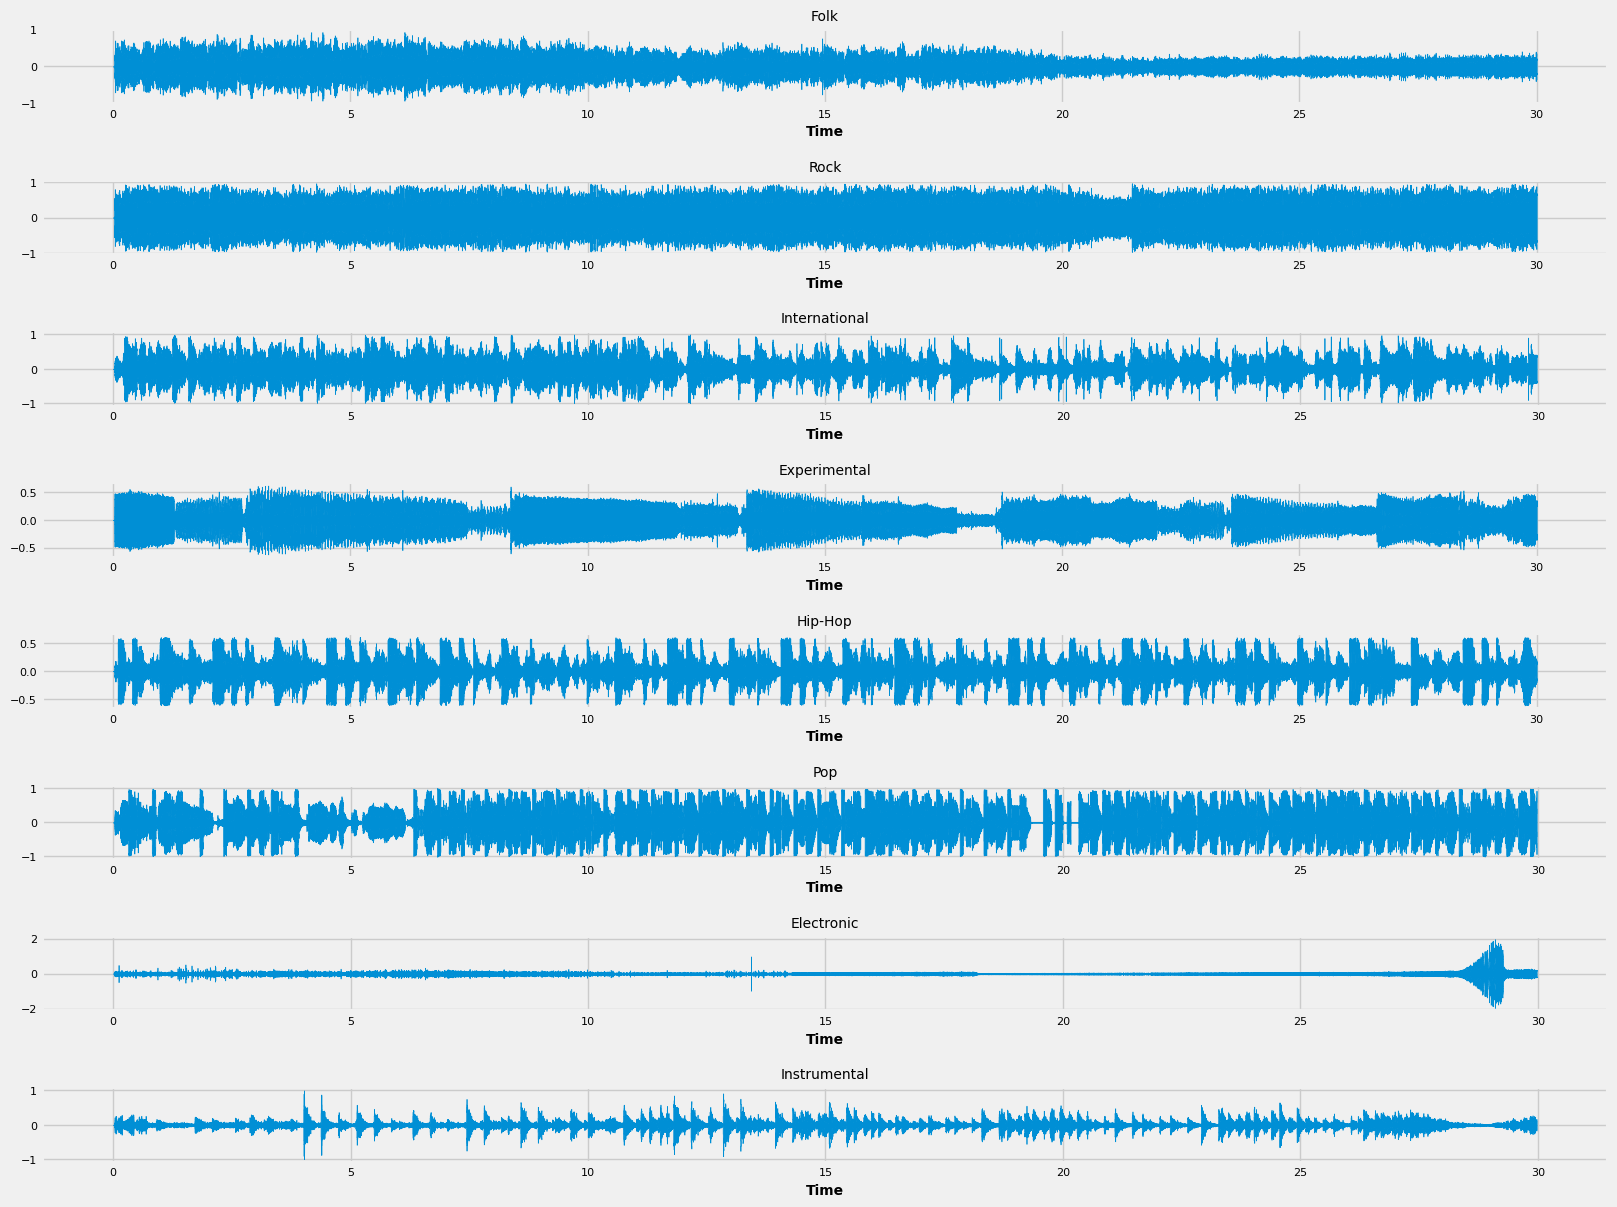

In [10]:
plt.figure(figsize=(18, 14))

i=1

for x in genres:

    plt.subplot(8, 1, i)
    plt.subplots_adjust(hspace = 1 )
    librosa.display.waveshow(x, sr=sr)
    plt.title(genres_List[i-1])
    i=i+1

$$ ZERO \ CROSSING \ RATE $$

Il Zero Crossing Rate è il rapporto tra il numero di volte in cui il segnale cambia segno in $t$ punti e l'intervallo T. I punti $t$ appartengono a T.

Di solito ha valori più alti per suoni altamente percussivi come quelli del rock, più bassi per quelli meno percussivi come quelli del pop.

Corrisponde alla formula:

$$ ZCR = \frac{1}{T-1}\sum_{t=1}^{T-1} I_{(-\infty,0)}(s_{t-1}s_{t}) $$

dove: 

   - T è la lunghezza di ogni intervallo
   - s è il segnale
   - I è la funzione indicatrice: $I_{(-\infty,0)}(s_{t-1}s_{t}) = 
\begin{cases} 
1 & \text{se } s_{t-1}s_{t} < 0 \\ 
0 & \text{altrimenti}
\end{cases}$
   
Di seguito viene riportato un grafico per ogni genere in cui si evidenzia il cambio di segno su una finestra della sequenza audio:

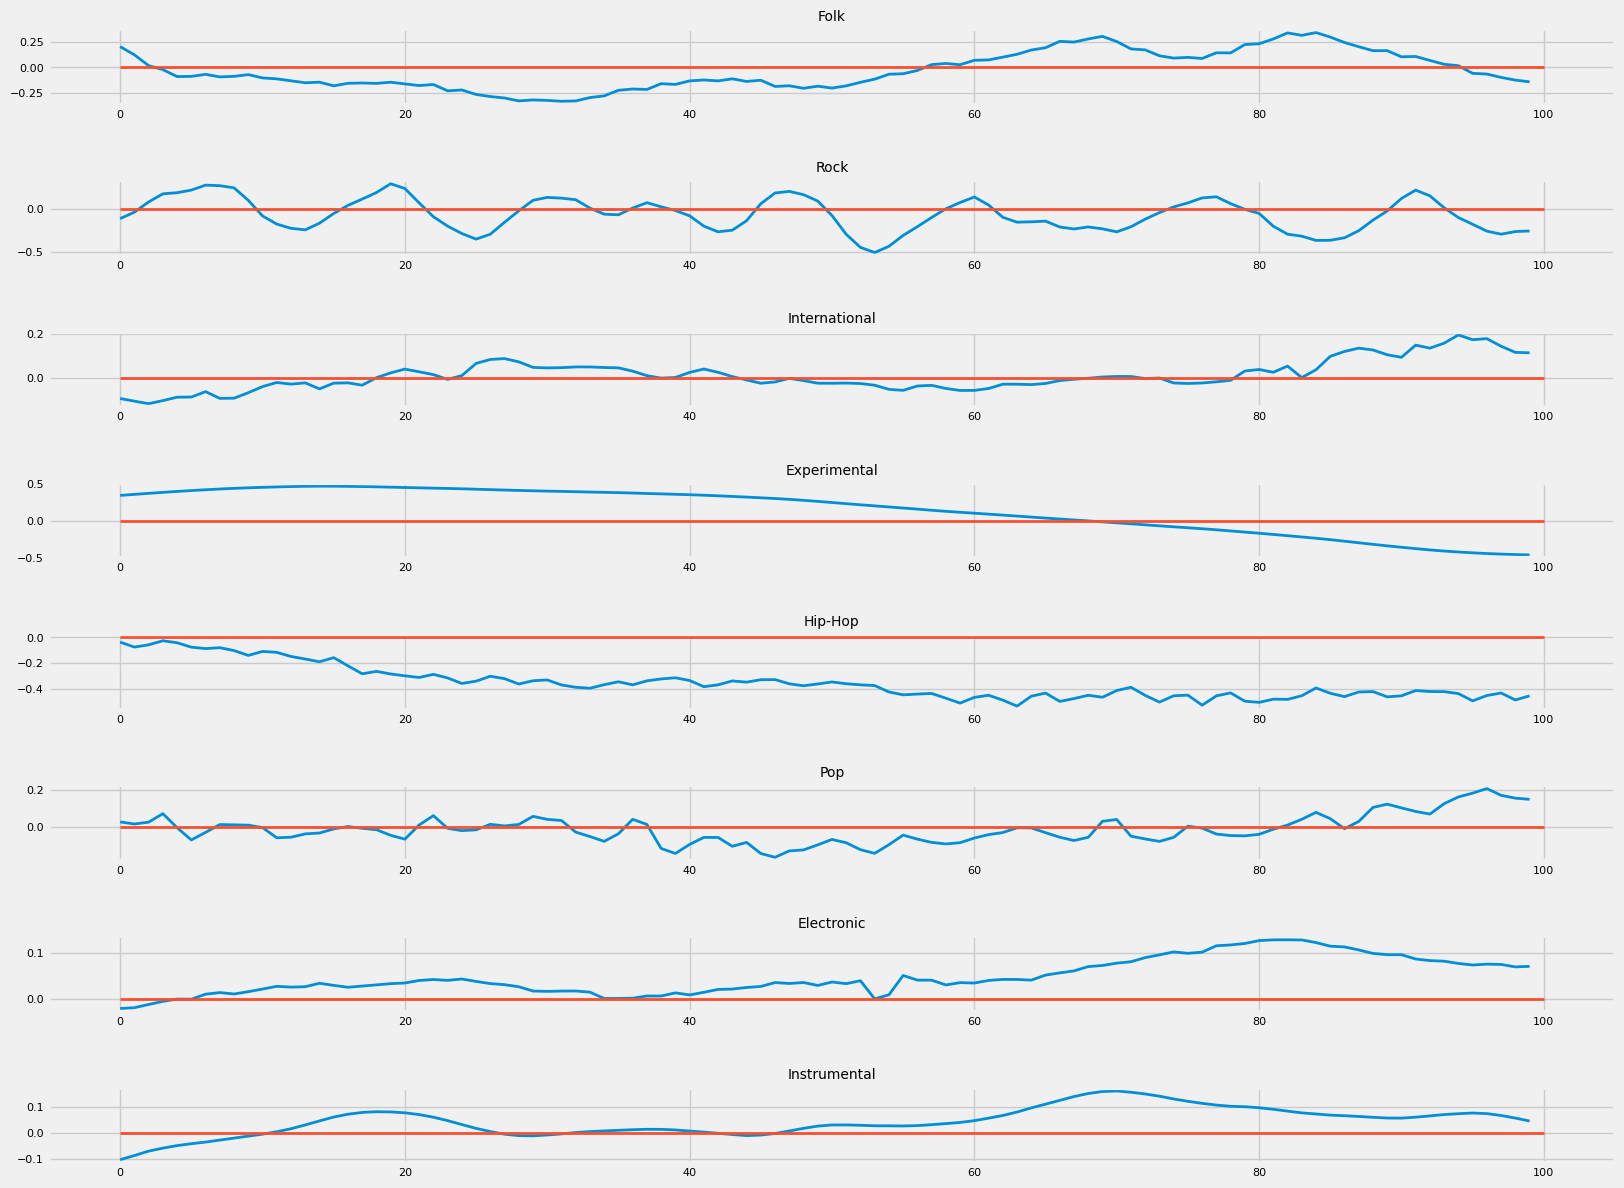

In [11]:
plt.figure(figsize=(18, 14))

i=1

n0 = 3100
n1 = 3200
zero = np.zeros(100)

for x in genres:
    
    plt.subplot(8, 1, i)
    plt.subplots_adjust(hspace = 1)
    plt.plot(x[n0:n1])
    plt.plot(np.linspace(0,100,100), zero)
    plt.title(genres_List[i-1])
    i=i+1

$$ Spectral \ Centroid $$

Il centroide spettrale è una misura usata nell'elaborazione digitale del segnale per caratterizzare uno spettro. Indica dove si trova il centro di massa dello spettro.

Ha una forte connessione  con la "brightness" di un suono.

Il termine "brightness" è usato nel contesto dei timbri sonori, in un'analogia approssimativa con la luminosità visiva. I ricercatori timbrici considerano la "brightness" come una delle distinzioni percettivamente più forti tra i suoni e la formalizzano acusticamente come indicazione della quantità di contenuto ad alta frequenza in un suono, utilizzando una misura come il centroide spettrale. 

Nei grafici seguenti abbiamo plottato lo Spectral Centroid sopra il grafico della frequenza.

Lo Spectral Centroid è calcolato su ogni frame del segnale audio e successivamente interpolato.

In [12]:
#Definisco una funzione di normalizzazione che mi servirà per costruire i grafici qui sotto

def normalize(x, axis=0):
    return preprocessing.minmax_scale(x, axis=axis)

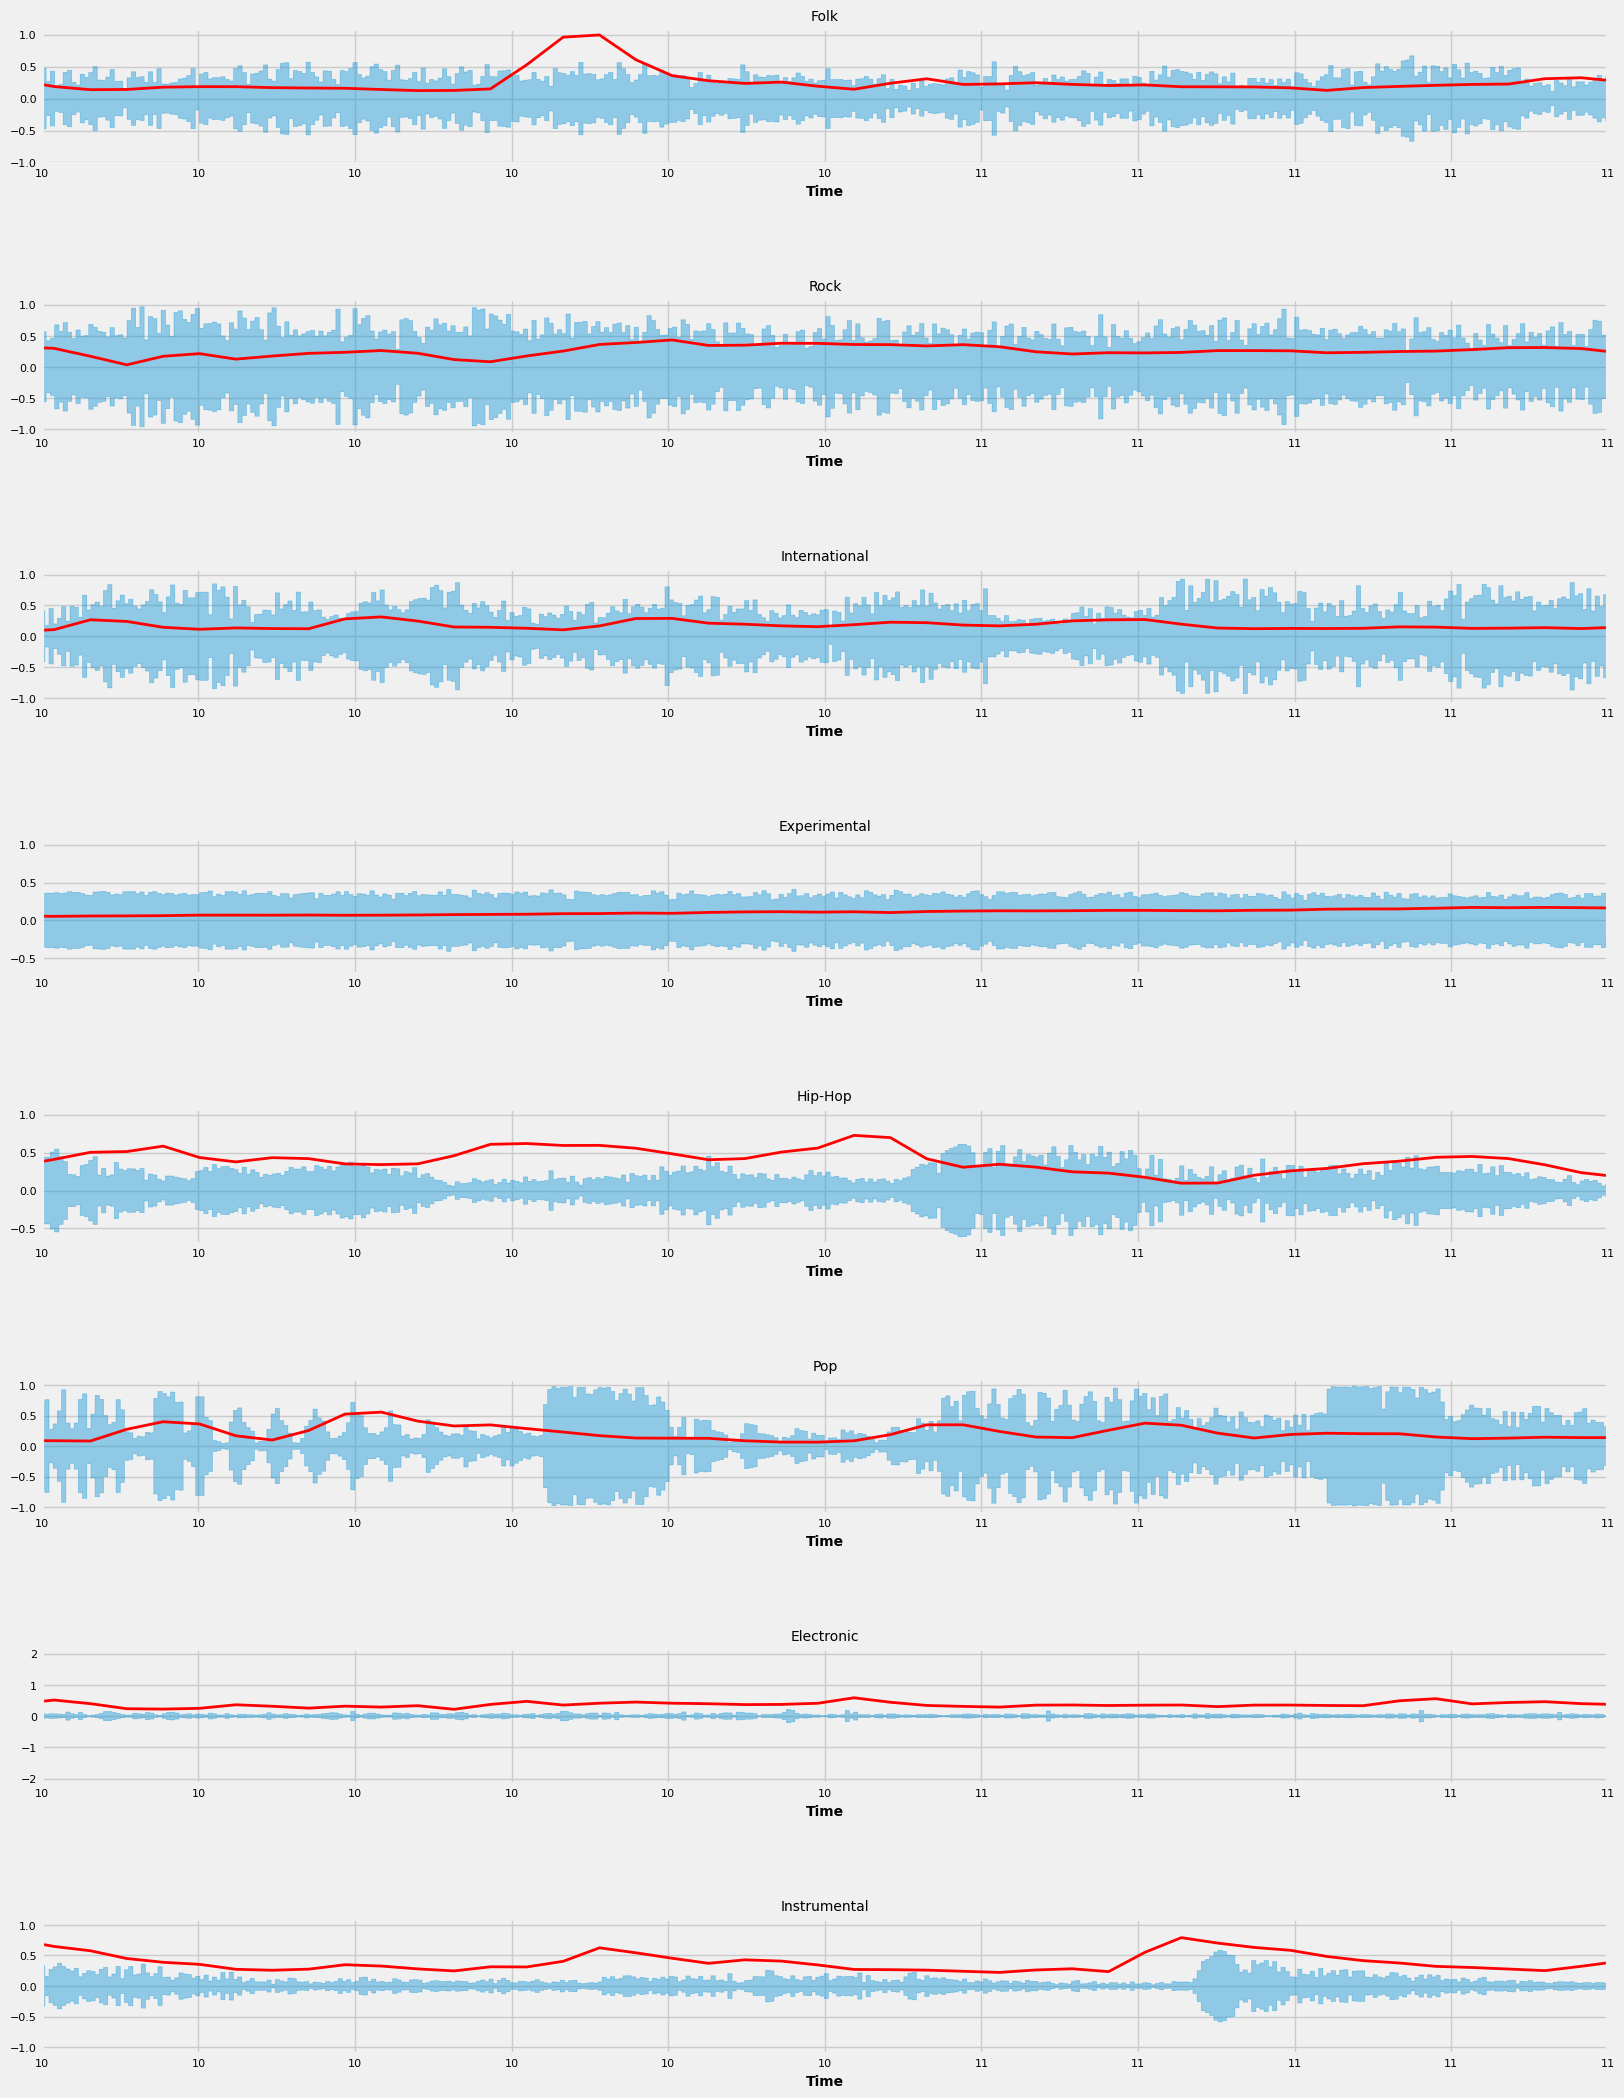

In [13]:
plt.figure(figsize=(18, 25))
i=1
for x in genres:

    plt.subplot(8, 1, i)

    # Calcolo la spectral centroid per ogni frame:
    spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)

    # Plotto il segnale audio e lo Spectral Centroid
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.xlim(10, 11)
    plt.title(genres_List[i-1])
    plt.subplots_adjust(hspace = 1)
    i=i+1

$$ Spectral Rolloff $$

È una misura della forma del segnale. Rappresenta la frequenza al di sotto della quale si trova una determinata percentuale dell'energia spettrale totale, ad esempio l'85%.

Nei grafici seguenti abbiamo plottato lo Spectral Rolloff sopra il grafico della frequenza.

Lo Spectral Rolloff è calcolato su ogni frame del segnale audio e successivamente interpolato.

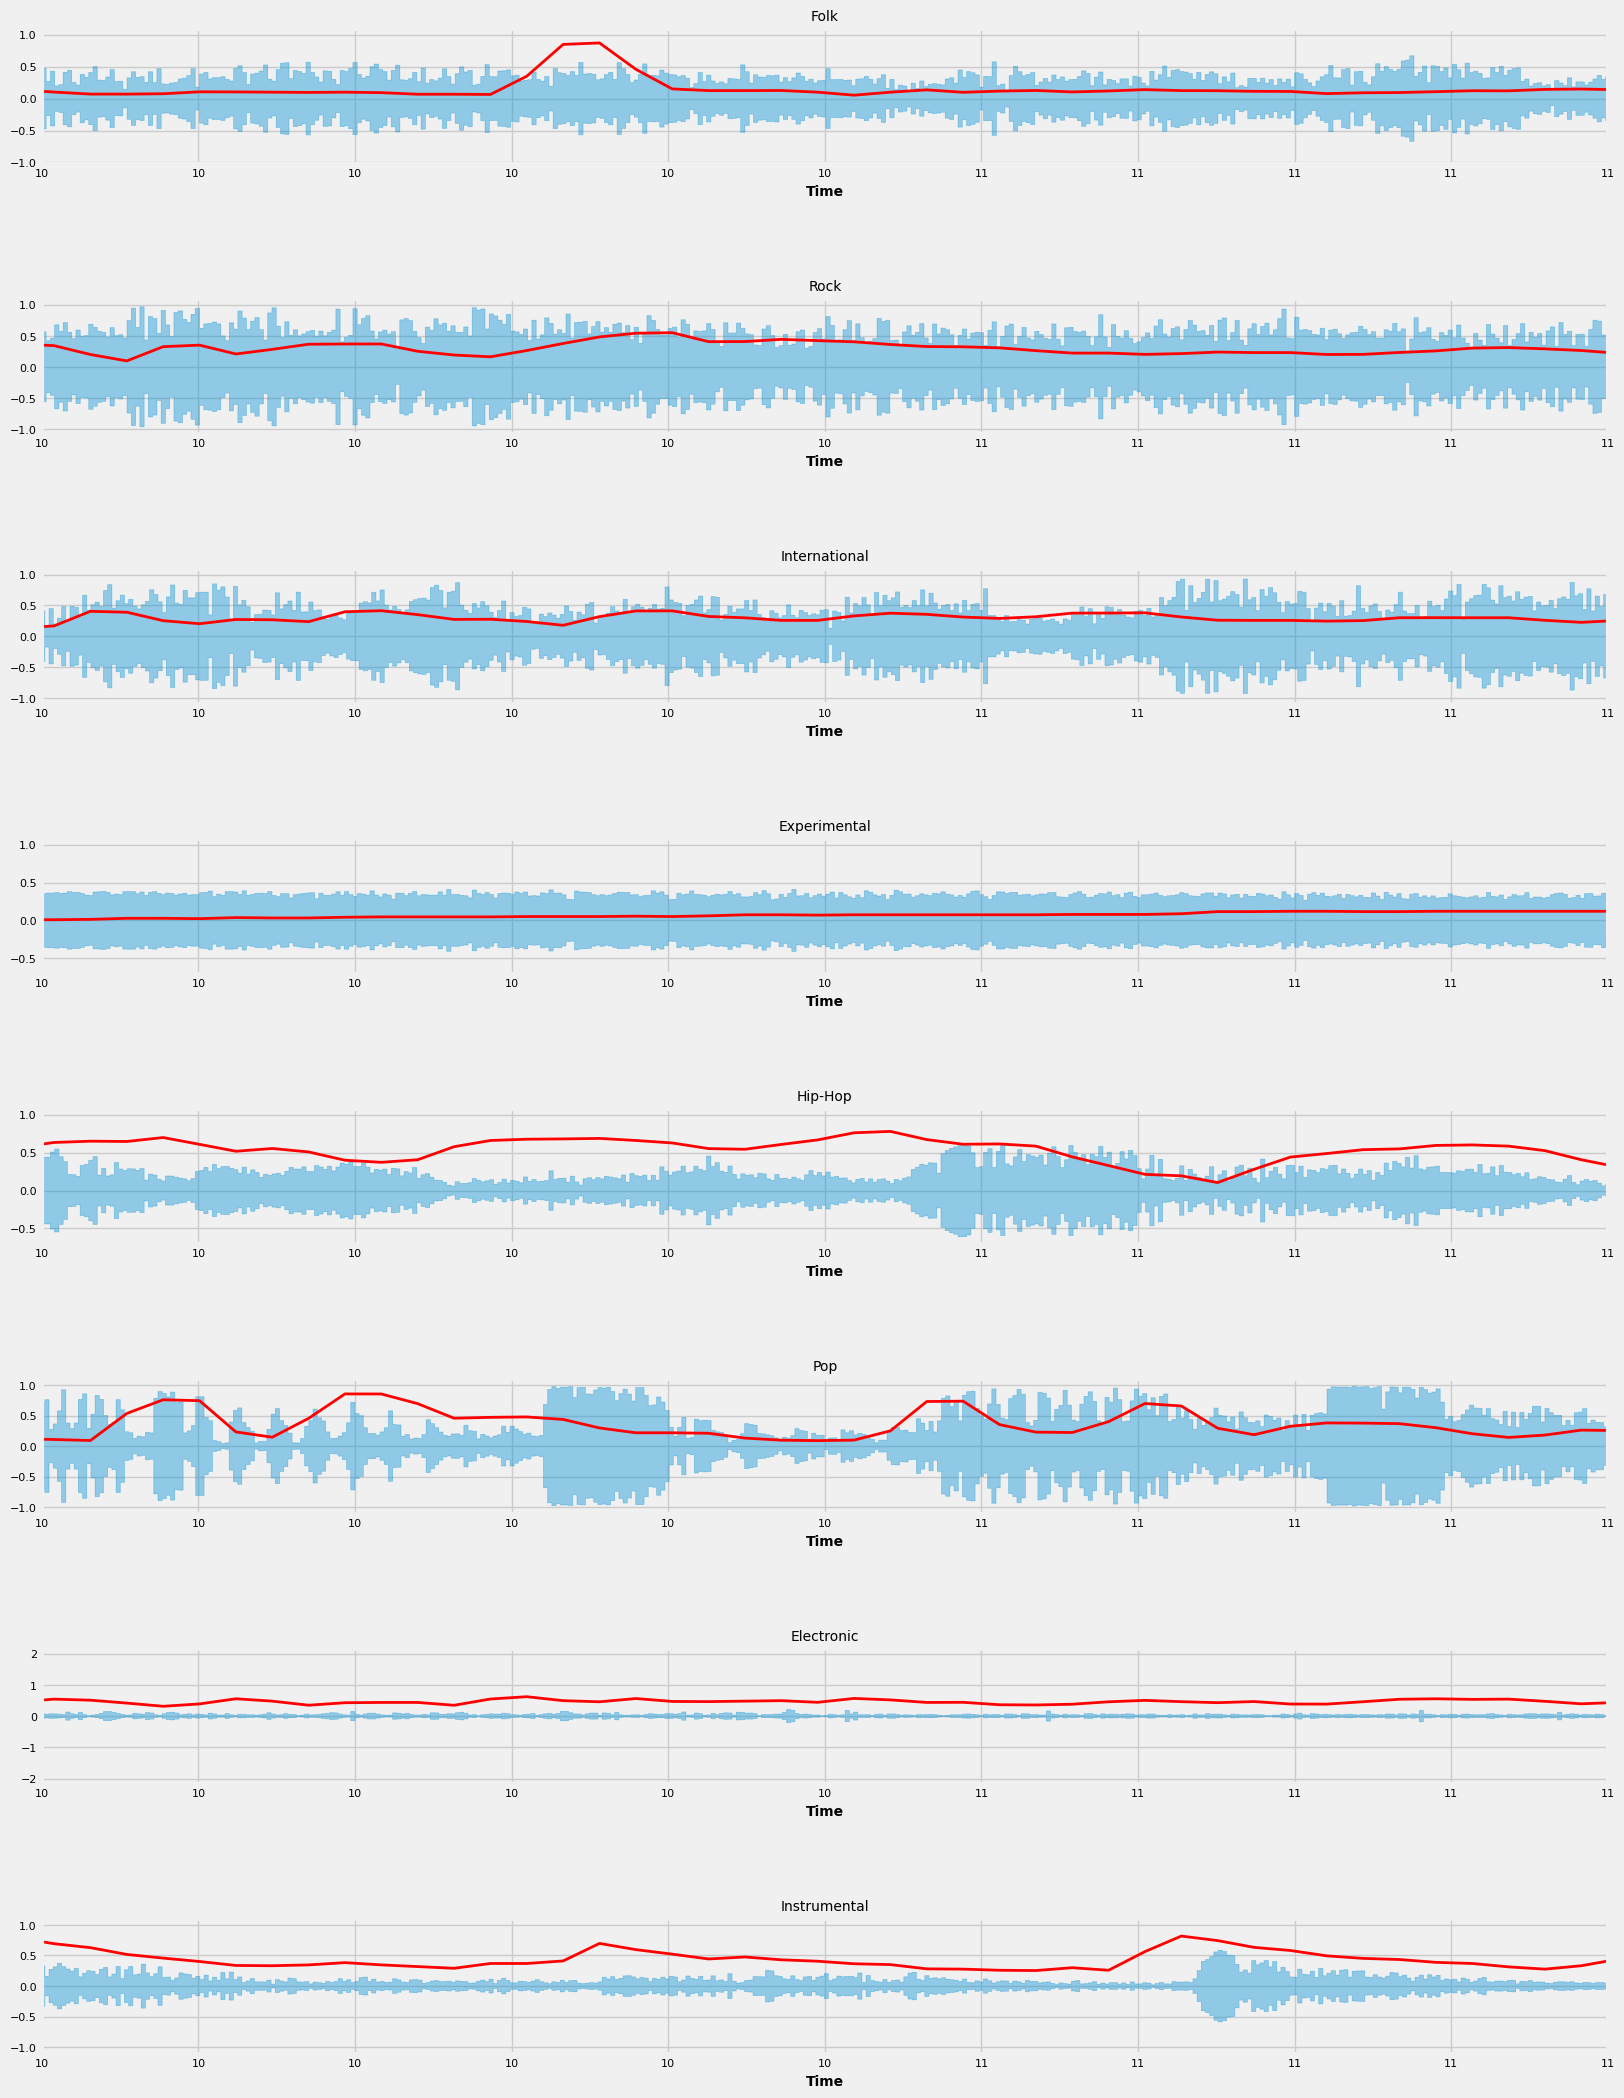

In [14]:
plt.figure(figsize=(18, 25))

i=1

for x in genres:

    plt.subplot(8, 1, i)

    # Calcolo la frequenza rolloff per ogni frame:
    spectral_rolloff = librosa.feature.spectral_rolloff(y=x+0.01, sr=sr)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)

    # Plotto il segnale audio e lo Spectral Rolloff
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.xlim(10, 11)
    plt.title(genres_List[i-1])
    plt.subplots_adjust(hspace = 1)
    i=i+1

$$ Spectral Bandwidth $$

Lo Spectral Bandwidth calcola la quantità (per ogni frame t):

$$ [\sum_{k}S(k,t)(f(k,t)-f_{c}(t))^{p}]^{\frac{1}{p}} $$

dove:

   - t è il frame ovvero in quanti intervalli è diviso il segnale audio 
   - k sono i bin, ovvero degli intervalli di una variabile consecutivi e non sovrapposti. Devono essere adiacenti e della stessa lunghezza
   - S(k,t) è la magnitudine spettrale alla frequenza bin k
   - f(k,t) è la frequenza al bin k
   - $f_{c}$ è lo Spectral Centroid
   - p è l'ordine
   
Quando p=2 (come nel nostro caso) questa quantità è come la deviazione standard, ma pesata.  

Nei grafici seguenti abbiamo plottato lo Spectral Bandwidth sopra il grafico della frequenza.

Lo Spectral Bandwidth è calcolato su ogni frame del segnale audio e successivamente interpolato.

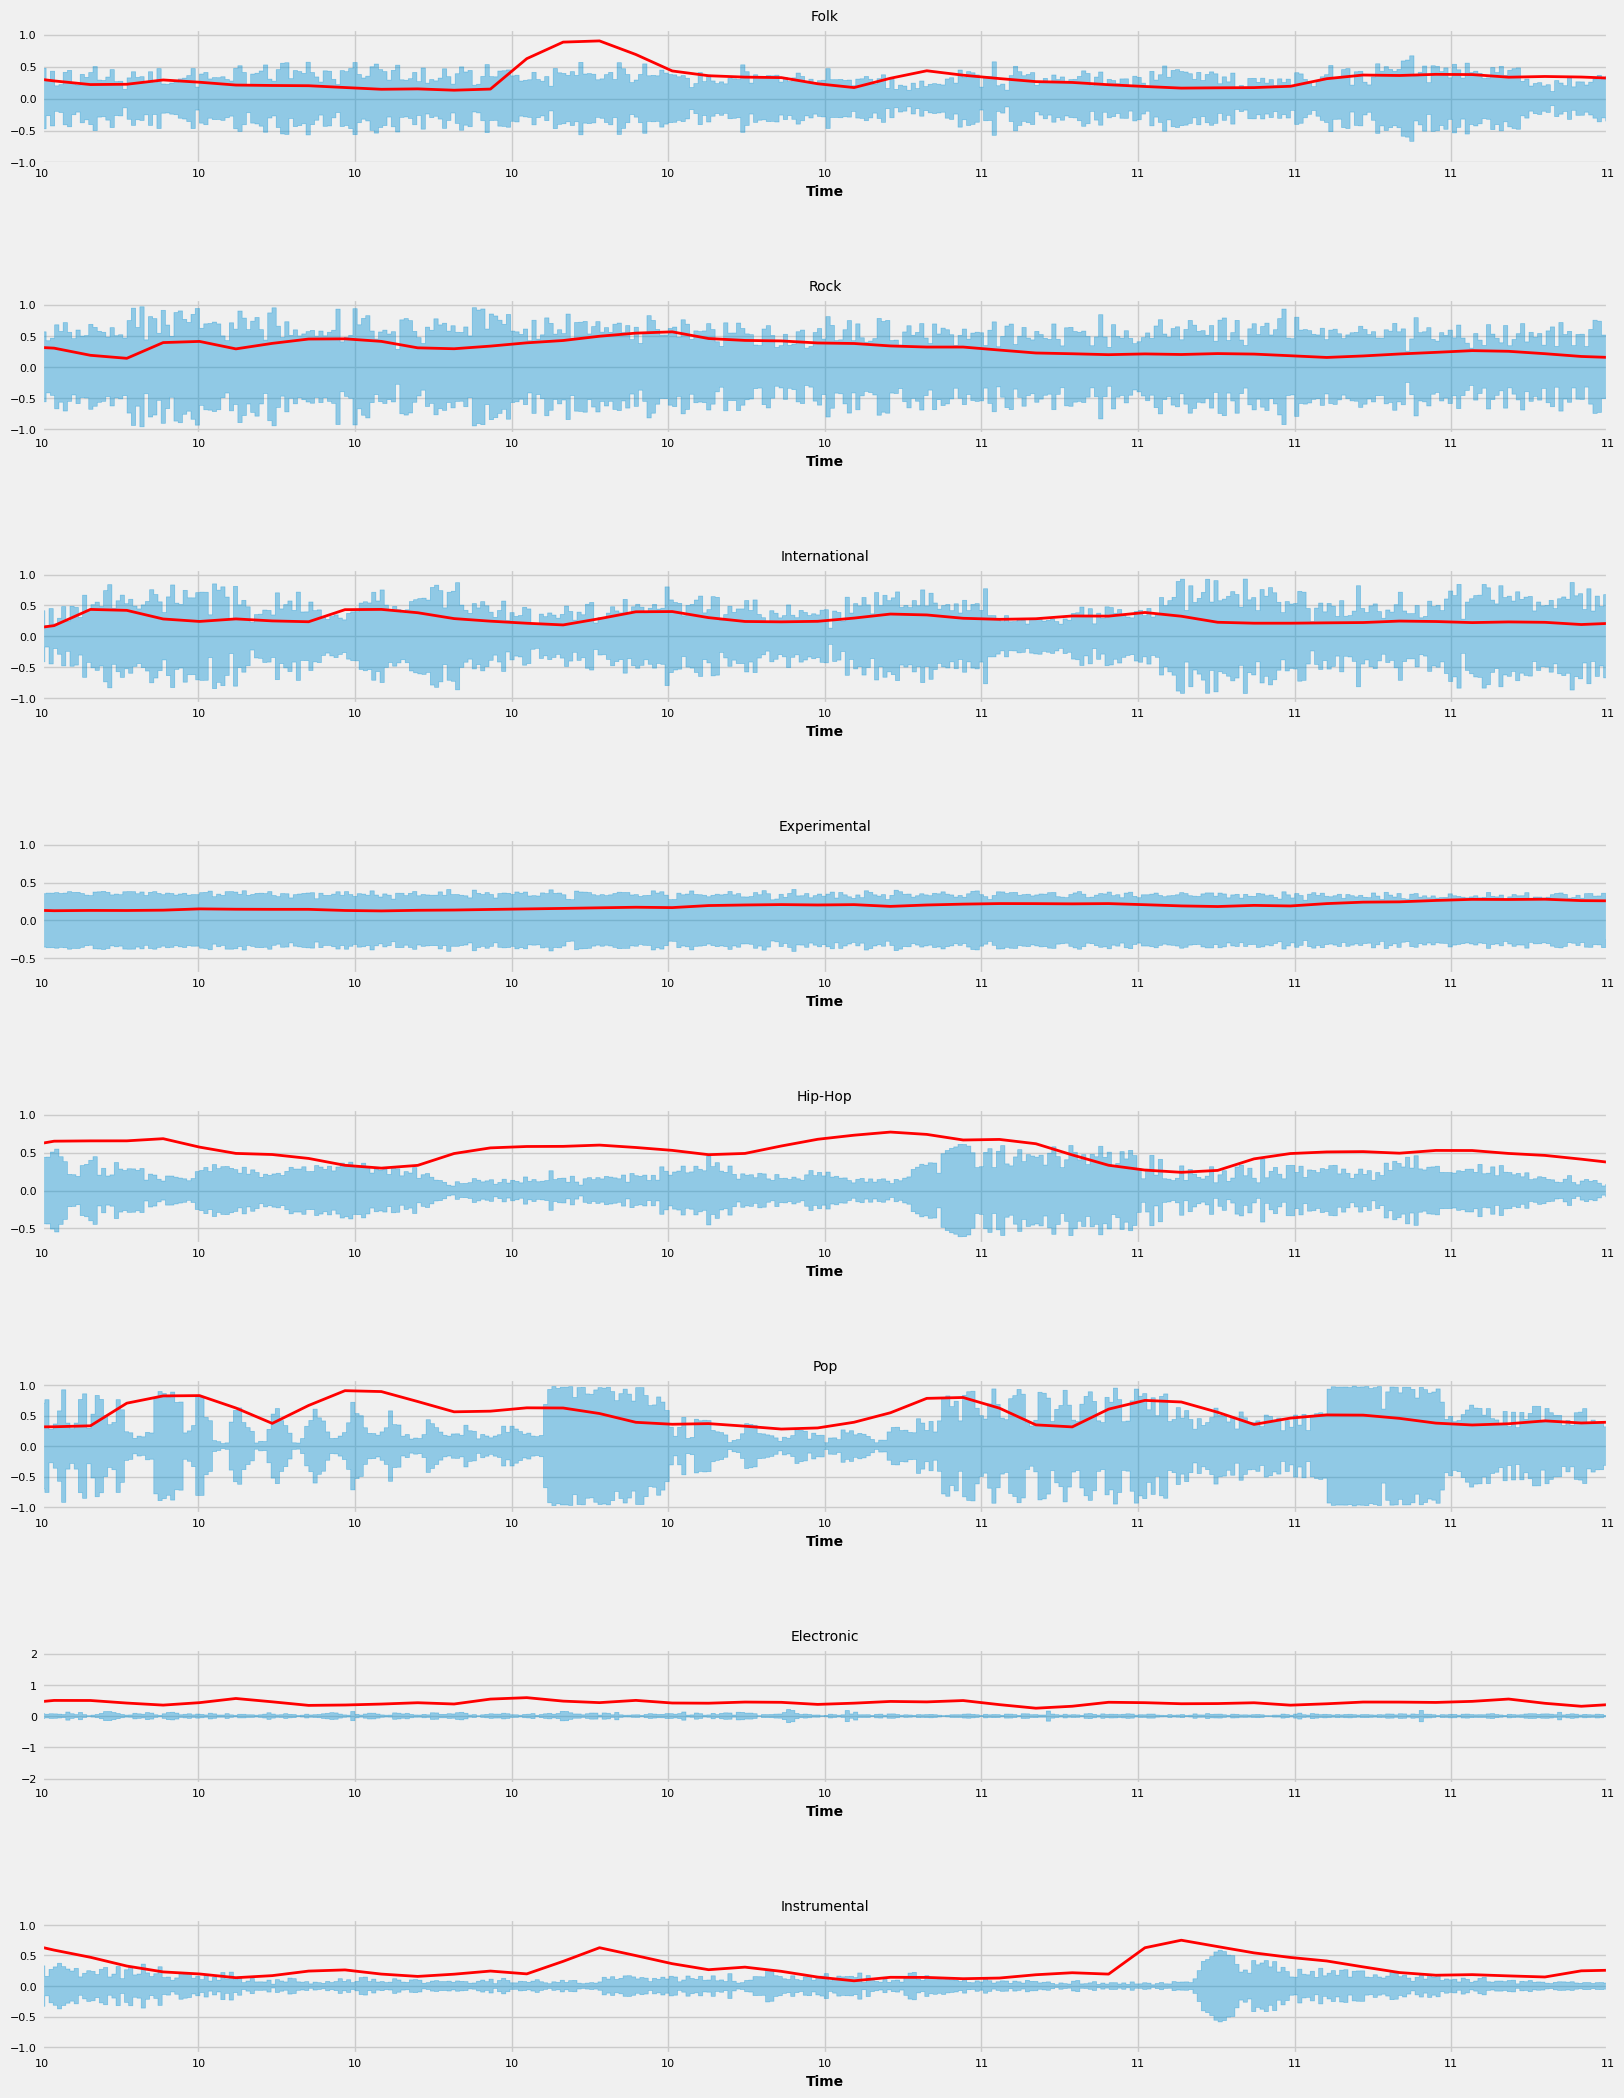

In [15]:
plt.figure(figsize=(18, 25))

i=1

for x in genres:

    plt.subplot(8, 1, i)

    # Calcolo la frequenza rolloff per ogni frame:
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=x+0.01, sr=sr)[0]
    frames = range(len(spectral_bandwidth))
    t = librosa.frames_to_time(frames)

    # Plotto il segnale audio e lo Spectral Rolloff
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_bandwidth), color='r')
    plt.xlim(10, 11)
    plt.title(genres_List[i-1])
    plt.subplots_adjust(hspace = 1)
    i=i+1

$$ Spectral \ Contrast $$

Ogni frame di uno spettrogramma S è diviso in sottobande. Per ogni sottobanda, lo Spectral Contrast è stimato confrontando lo spectral peak e lo spectral valley. Tali valori sono stimati dal valore medio in un intorno del valore rispettivamente massimo e minimo.

Valori di contrasto elevati corrispondono generalmente a segnali chiari e a banda stretta, mentre valori di contrasto bassi corrispondono al rumore a banda larga.

Nei grafici seguenti abbiamo plottato lo Spectral Contrast sopra il grafico della frequenza.

Lo Spectral Contrast è calcolato su ogni frame del segnale audio e successivamente interpolato.

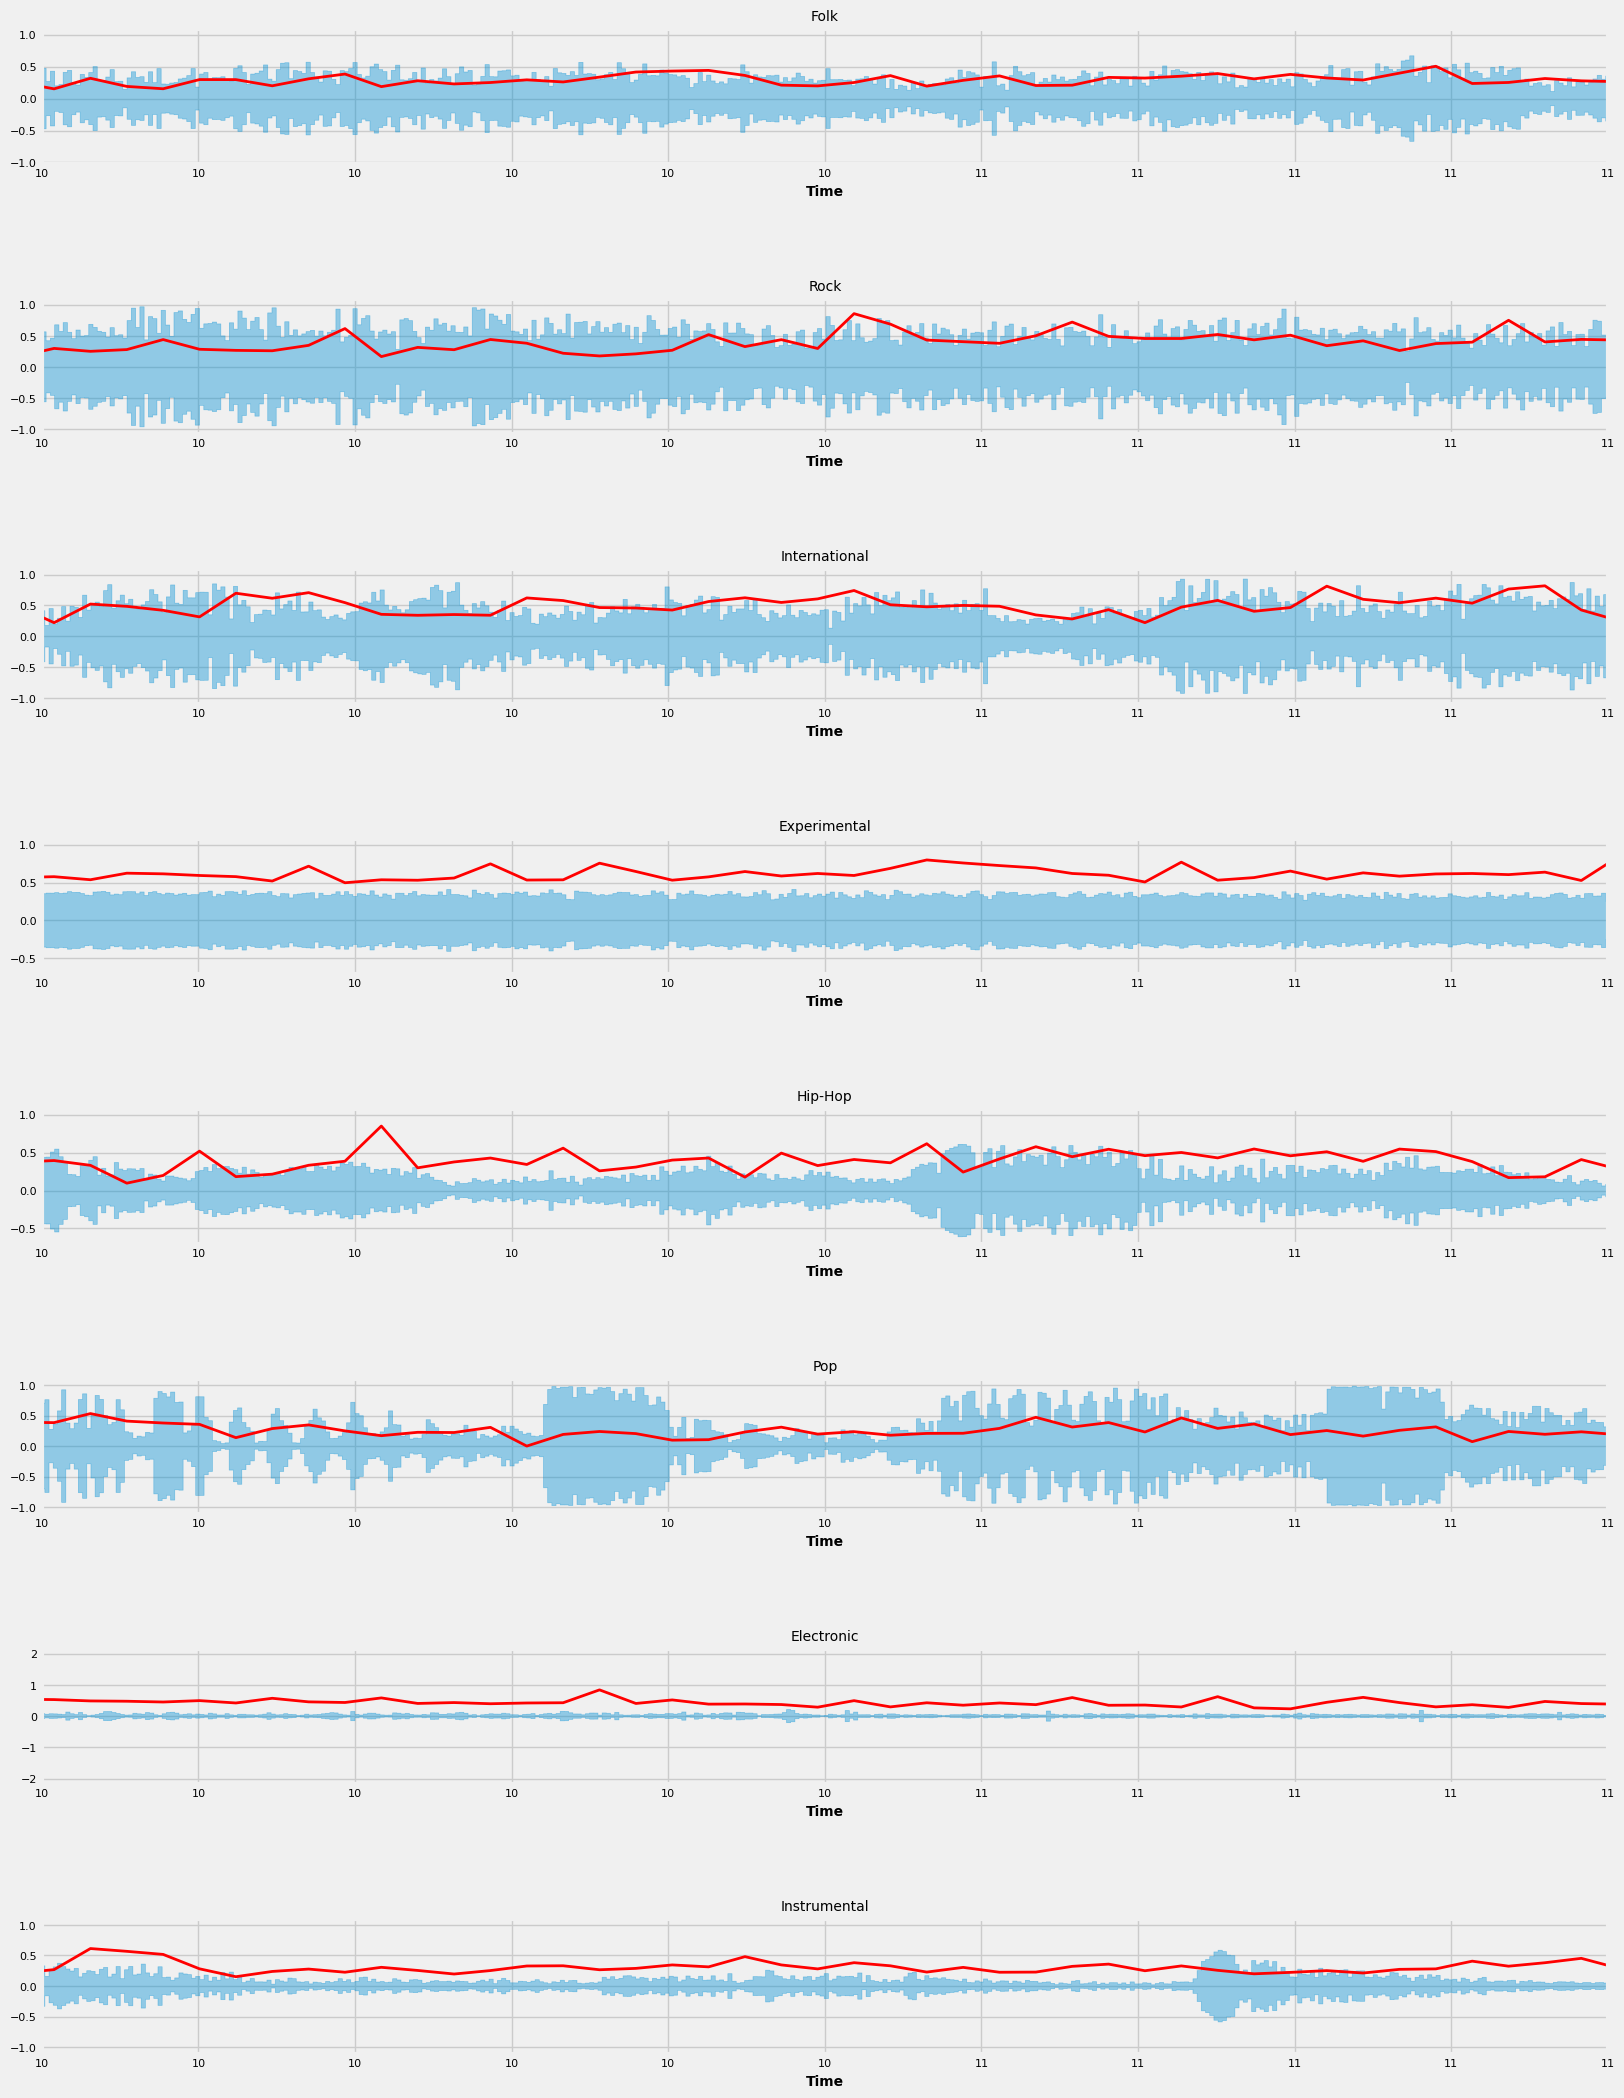

In [16]:
plt.figure(figsize=(18, 25))

i=1

for x in genres:

    plt.subplot(8, 1, i)

    # Calcolo la frequenza rolloff per ogni frame:
    spectral_contrast = librosa.feature.spectral_contrast(y=x+0.01, sr=sr)[0]
    frames = range(len(spectral_contrast))
    t = librosa.frames_to_time(frames)

    # Plotto il segnale audio e lo Spectral Rolloff
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_contrast), color='r')
    plt.xlim(10, 11)
    plt.title(genres_List[i-1])
    plt.subplots_adjust(hspace = 1)
    i=i+1

$$ Mel-Frequency \ Cepstral \ Coefficients \ (MFCCs) $$

I "mel frequency cepstral coefficients" (MFCCs) di un segnale sono un insieme di 20 features che descrivono la forma complessiva di un inviluppo spettrale (linea ideale che individua le aree dello spettro con la massima energia). Nel Music Information Retrieval è spesso usato per descrivere il timbro.

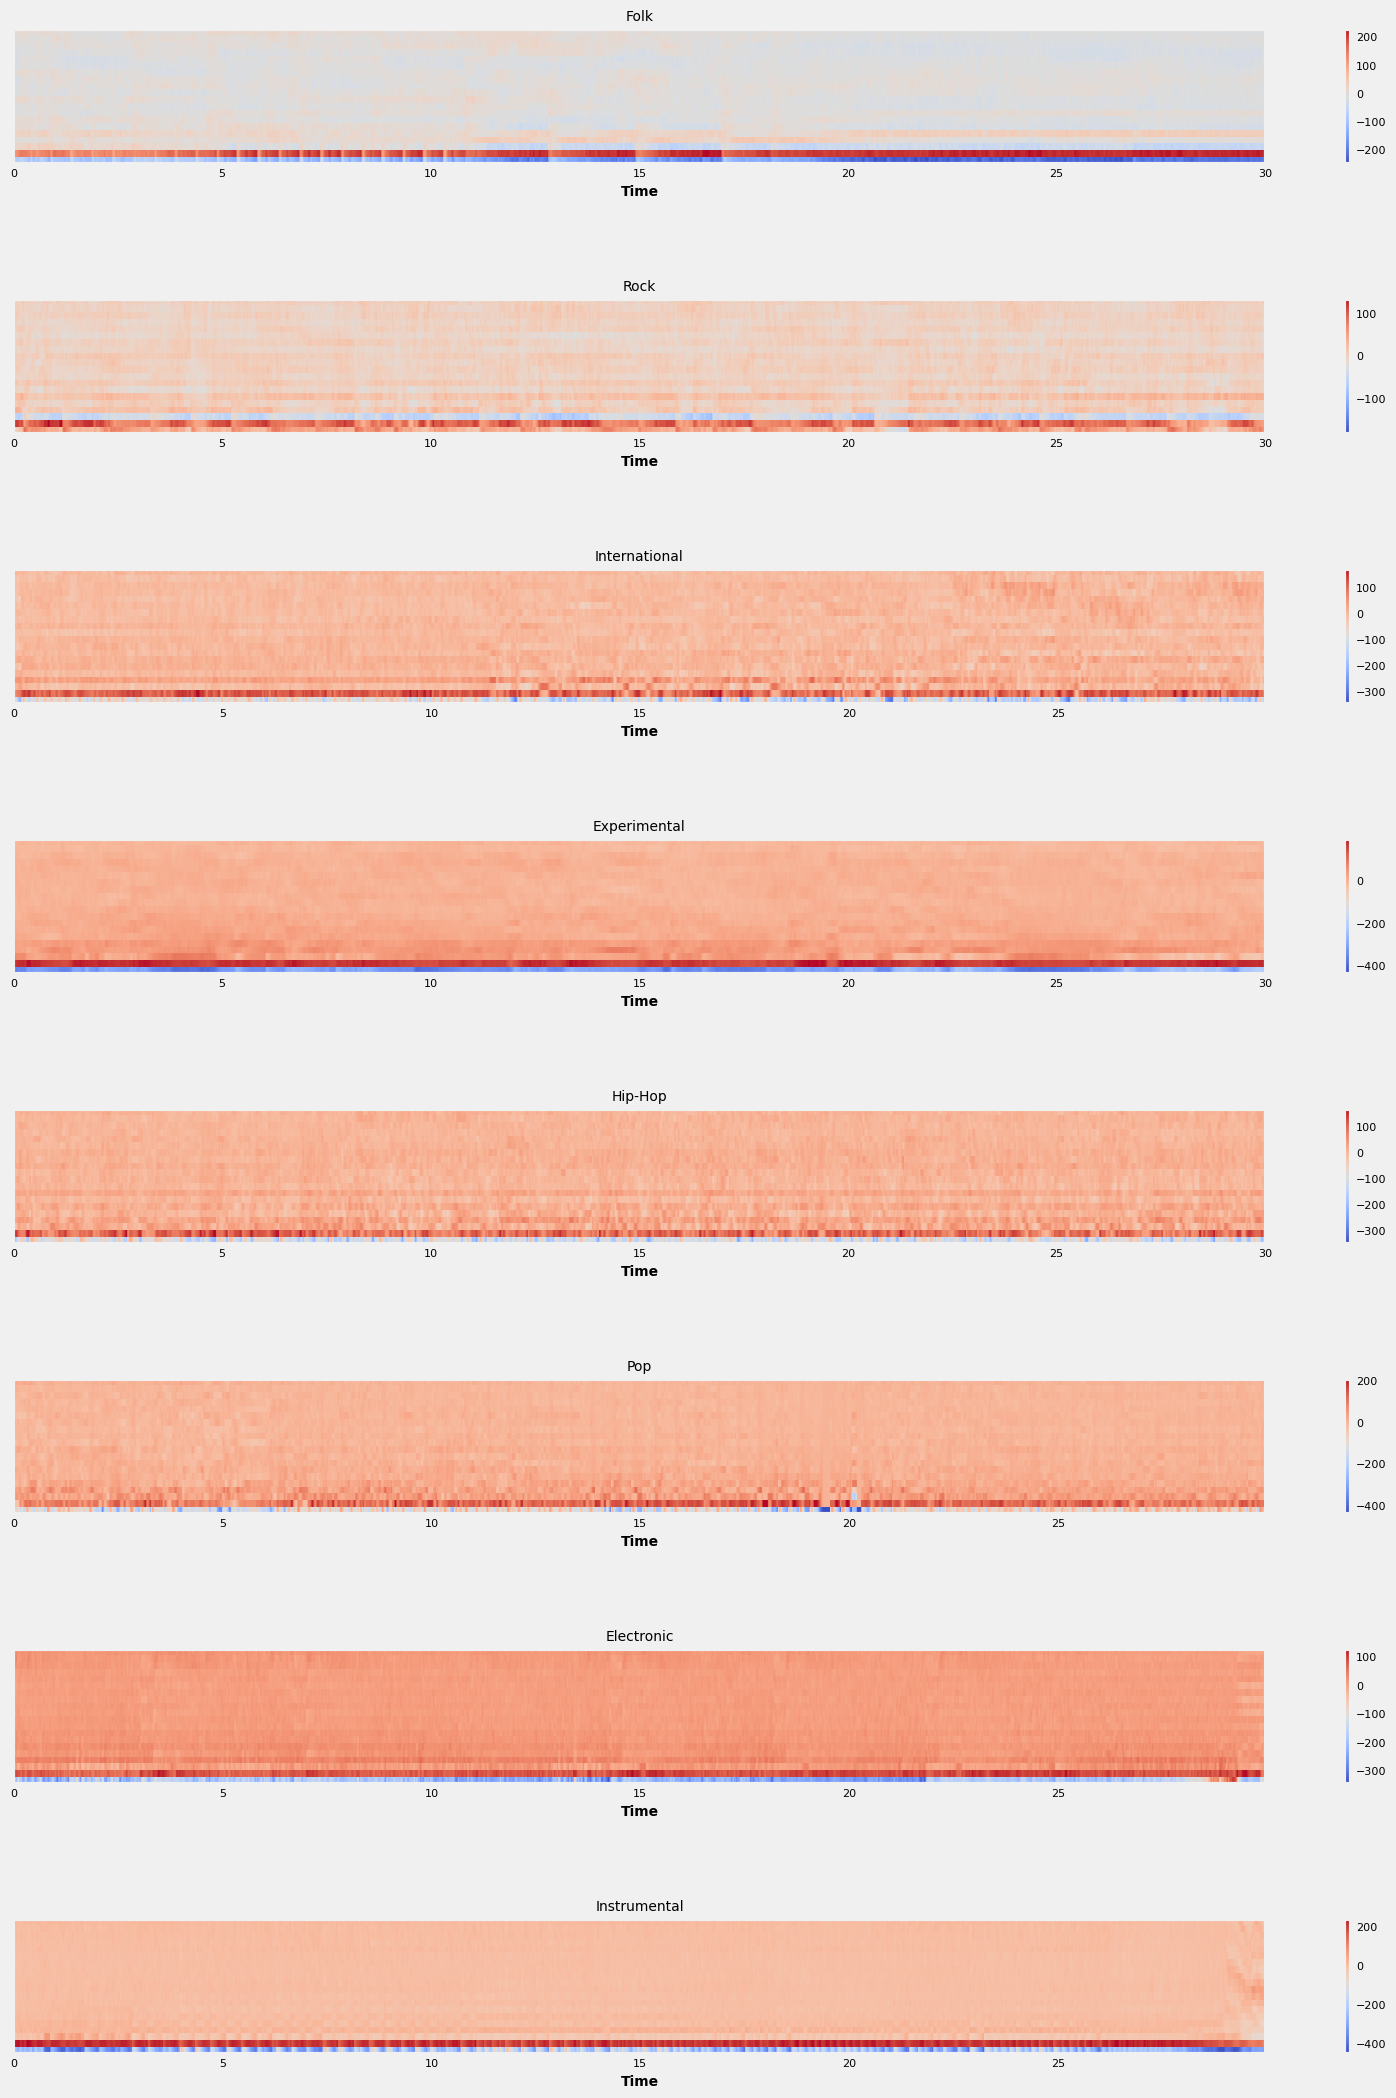

In [17]:
plt.figure(figsize=(18, 25))

i=1

for x in genres:

    plt.subplot(8, 1, i)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.title(genres_List[i-1])
    plt.colorbar()
    plt.subplots_adjust(hspace = 1)
    i=i+1

Possiamo anche eseguire la scalatura delle features in modo che ogni dimensione del coefficiente abbia una media pari a zero e una varianza unitaria:

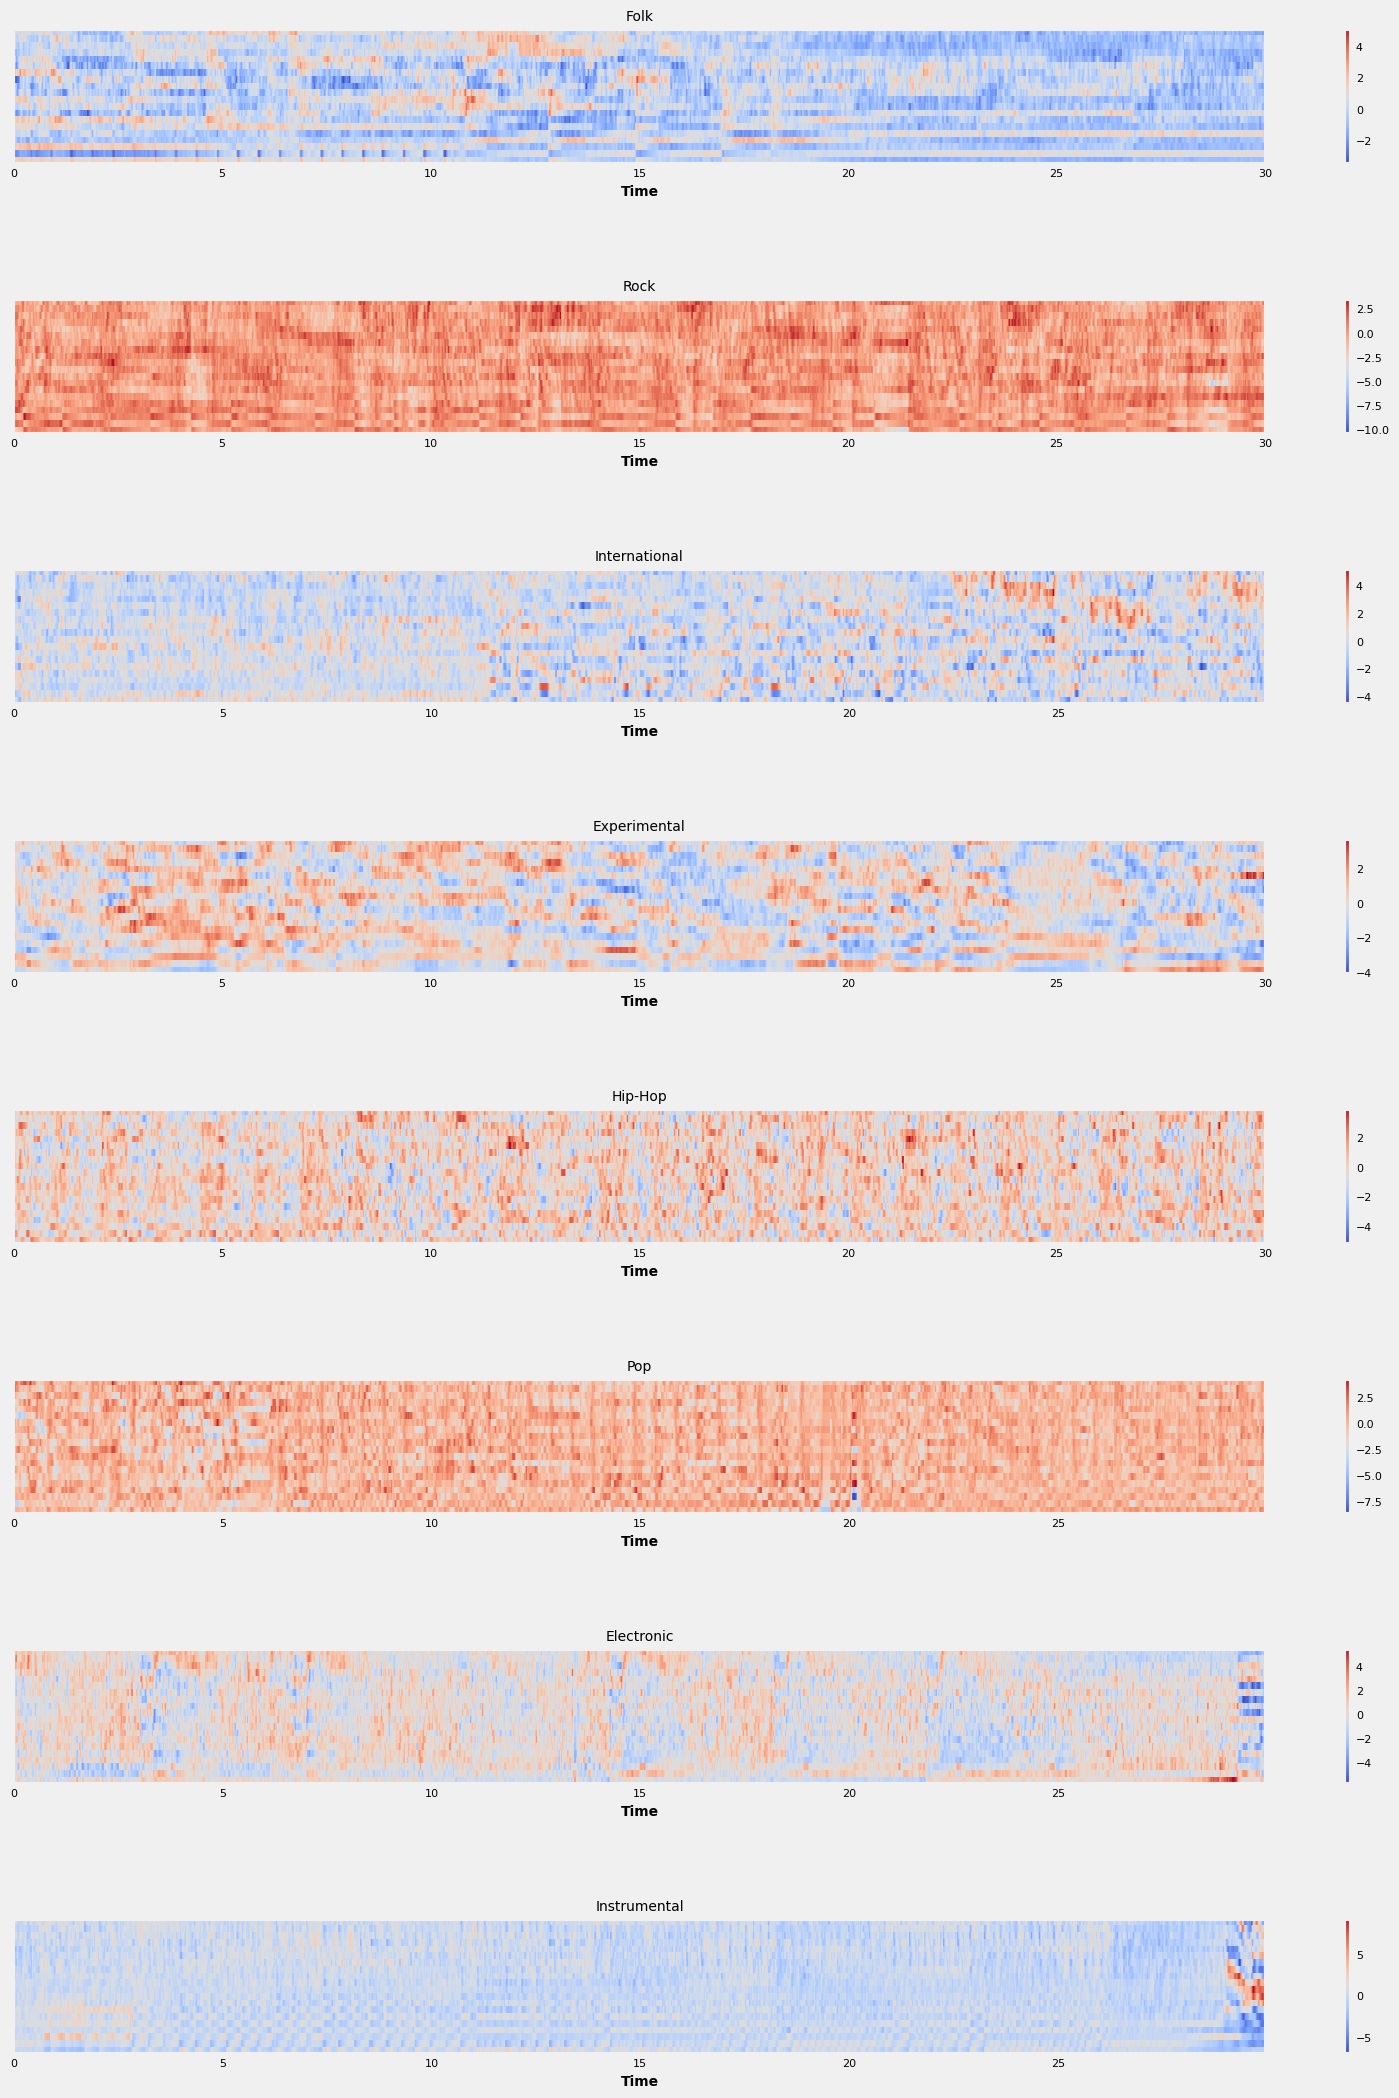

In [18]:
plt.figure(figsize=(18, 25))

i=1

for x in genres:

    plt.subplot(8, 1, i)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    mfccs = preprocessing.scale(mfccs, axis=1)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.title(genres_List[i-1])
    plt.colorbar()
    plt.subplots_adjust(hspace = 1)
    i=i+1


$$ Chroma \ Frequencies $$

Le features "Chroma" sono una rappresentazione delle tracce audio in cui l'intero spettro è proiettato su 12 bins che rappresentano i 12 distinti semitoni dell'ottava musicale. Poiché, in musica, le note a distanza di un'ottava sono percepite come particolarmente simili, conoscere la distribuzione del "Chroma" (anche senza conoscere l'ottava originale) può dare utili informazioni e rivelare una somiglianza musicale che non è evidente negli spettri originali. Una delle principali proprietà del "Chroma" è che catturano le caratteristiche armoniche e melodiche della musica, pur essendo robuste ai cambiamenti di timbro e di strumentazione. 

Abbiamo costruito le features "Chroma" in due modi diversi. Con la classica Short Time Fourier Transform e con la Constant-Q Transform. A differenza della trasformata di Fourier la trasformata Constant-Q utilizza un asse di frequenza a spaziatura logaritmica.

Abbiamo inoltre costruito la features "Chroma CENS" (Chroma Energy Normalized) nel seguente modo: otteniamo i 12 Chroma vettori  tramite la trasformazione Constant-Q, si normalizzano in norma L1 e si applica una funzione di quantizzazione che ha codominio discreto e finito. Questa trasformazione è applicata ad ogni componente dei 12 vettori chroma a cui viene associato un numero indicativo di una certa energia.

In [19]:
cqt = np.abs(librosa.cqt(Folk, sr=sr, hop_length=512, bins_per_octave=12,
                                     n_bins=7*12, tuning=None))
f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)

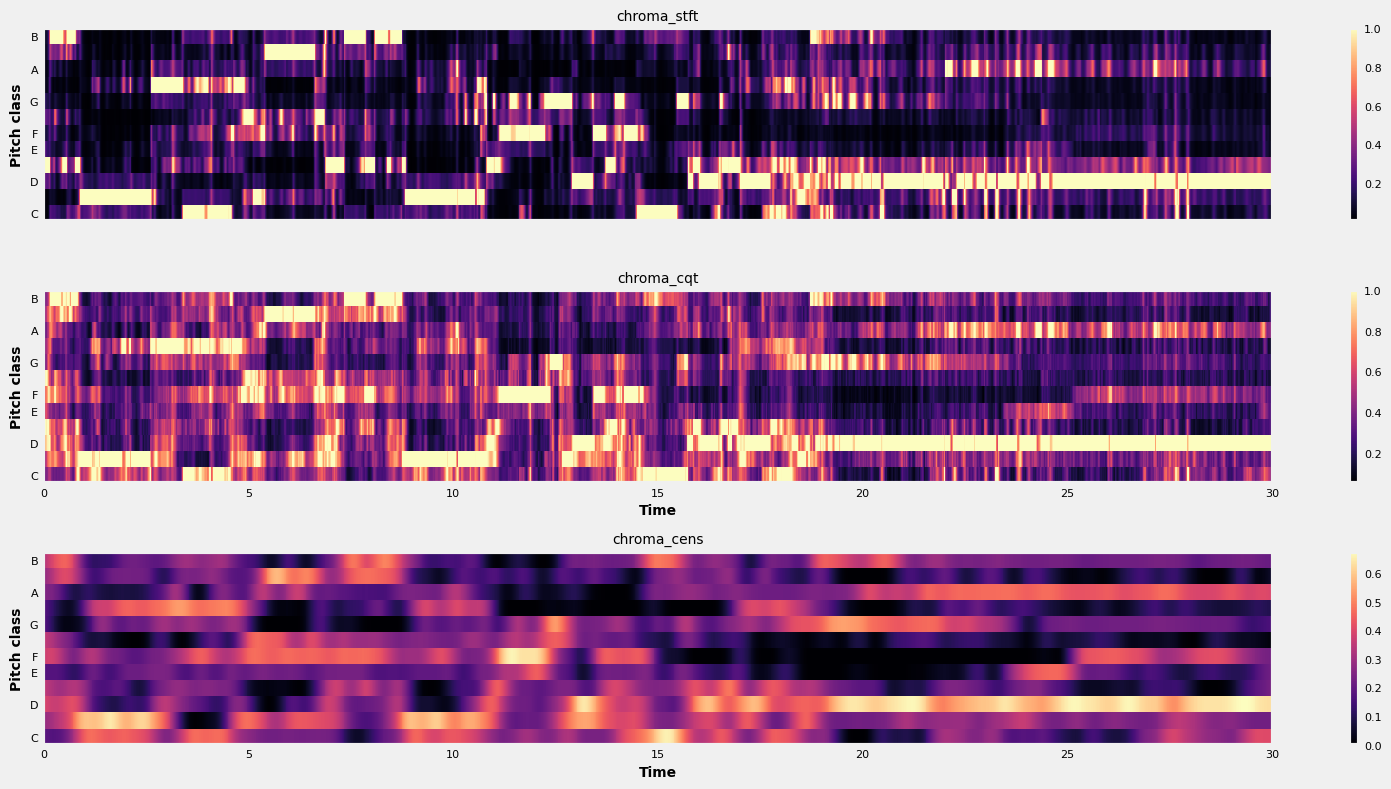

In [20]:
plt.figure()

y=Folk
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=4096)
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)

plt.subplot(3,1,1)
librosa.display.specshow(chroma_stft, y_axis='chroma')
plt.title('chroma_stft')
plt.colorbar()
plt.subplot(3,1,2)
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.title('chroma_cqt')
plt.colorbar()
plt.subplot(3,1,3)
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.title('chroma_cens')
plt.colorbar()

plt.tight_layout()
plt.show()

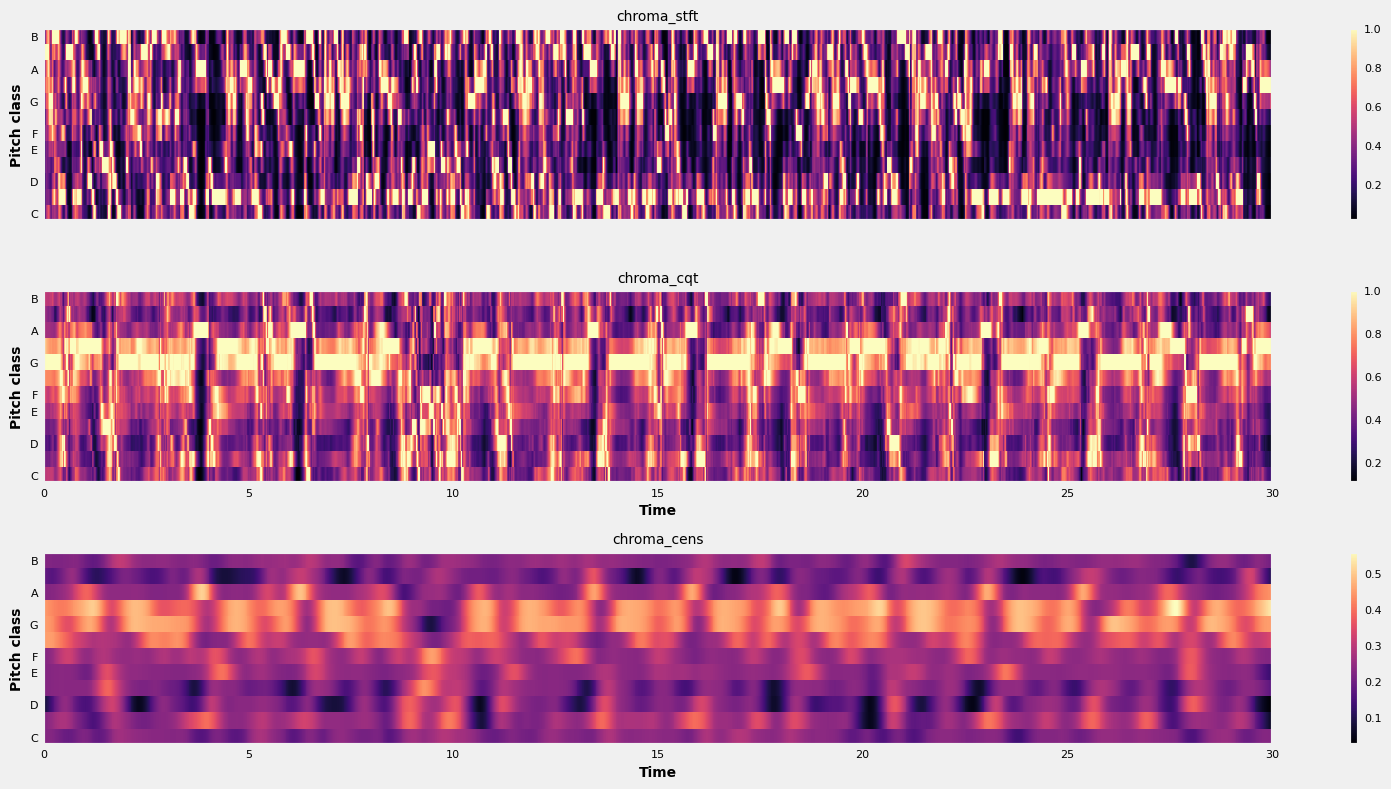

In [21]:
plt.figure()

y=Hip_Hop
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=4096)
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)

plt.subplot(3,1,1)
librosa.display.specshow(chroma_stft, y_axis='chroma')
plt.title('chroma_stft')
plt.colorbar()
plt.subplot(3,1,2)
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.title('chroma_cqt')
plt.colorbar()
plt.subplot(3,1,3)
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.title('chroma_cens')
plt.colorbar()

plt.tight_layout()
plt.show()

$$ Tonnetz $$

Vediamo come costruire la feature Tonnetz:
- otteniamo 12 Chroma vectors tramite la Constant-Q Transform e calcoliamo le features Chroma Cens. 

- mappiamo le features Chroma Cens, tramite la trasformazione "tonal centroid", all'interno dello spazio di un politopo 6-dimensionale, detto spazio tonale. 

- le nostre pitch classes sono quindi mappate all'interno dei vertici del politopo (l'analogo di un poligono nel piano, ma in uno spazio d-dimensionale).

- otteniamo quindi i tonal centroid vectors (vettori 6 dimensionali), tra i quali applichiamo la funzione Harmonic Change Detection Function, ovvero la distanza euclidea tra due vettori.

Relazioni armoniche vicine come le "terze" o le "quinte" appaiono con distanze molto piccole, invece dei picchi in tale funzione denotano delle transizioni da zone armonicamente stabili in altre.

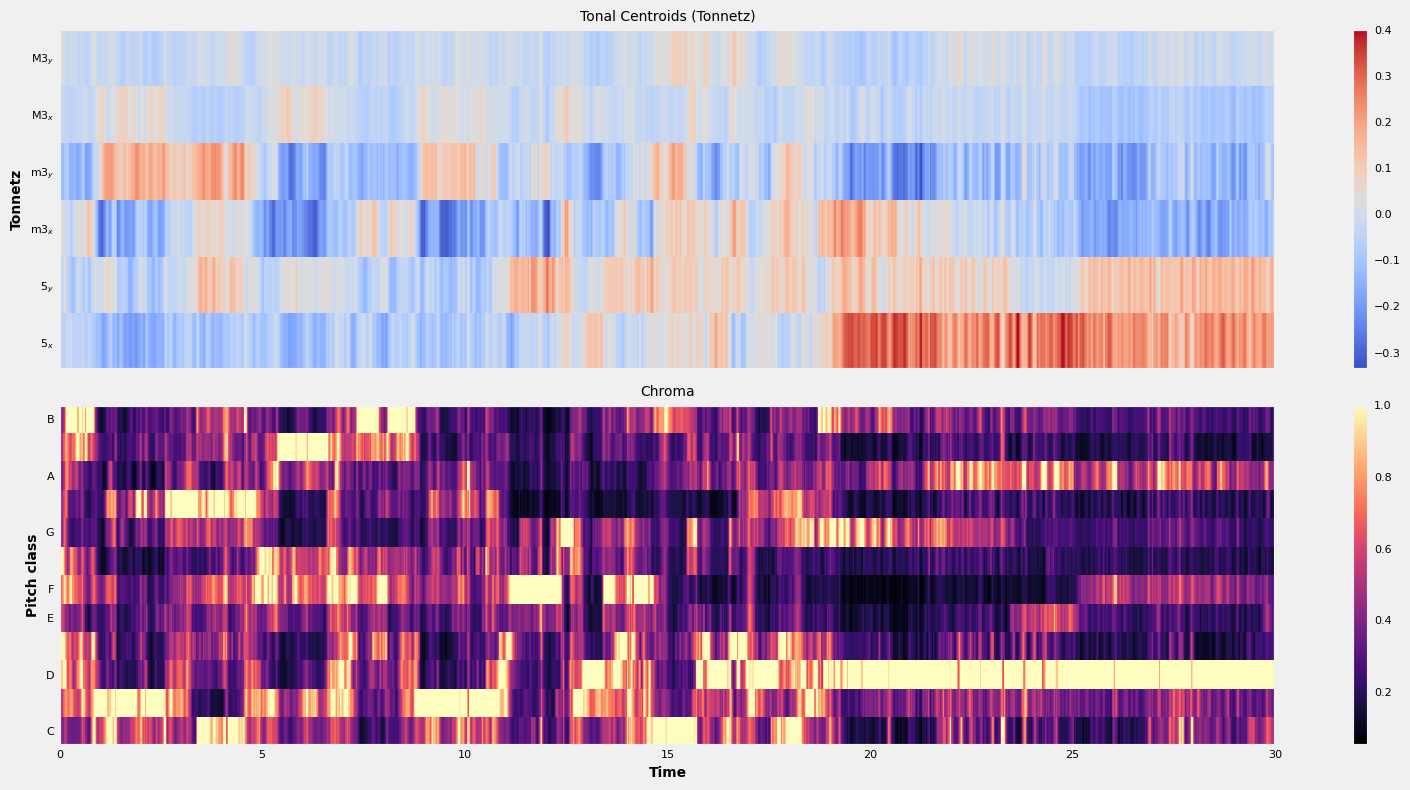

In [22]:
x = Folk

tonnetz = librosa.feature.tonnetz(y=x, sr=sr)
#x = librosa.effects.harmonic(x)
plt.subplot(2, 1, 1)
librosa.display.specshow(tonnetz, y_axis='tonnetz')
plt.colorbar()
plt.title('Tonal Centroids (Tonnetz)')
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.feature.chroma_cqt(y=x, sr=sr),
                         y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma')
plt.tight_layout()
plt.show()

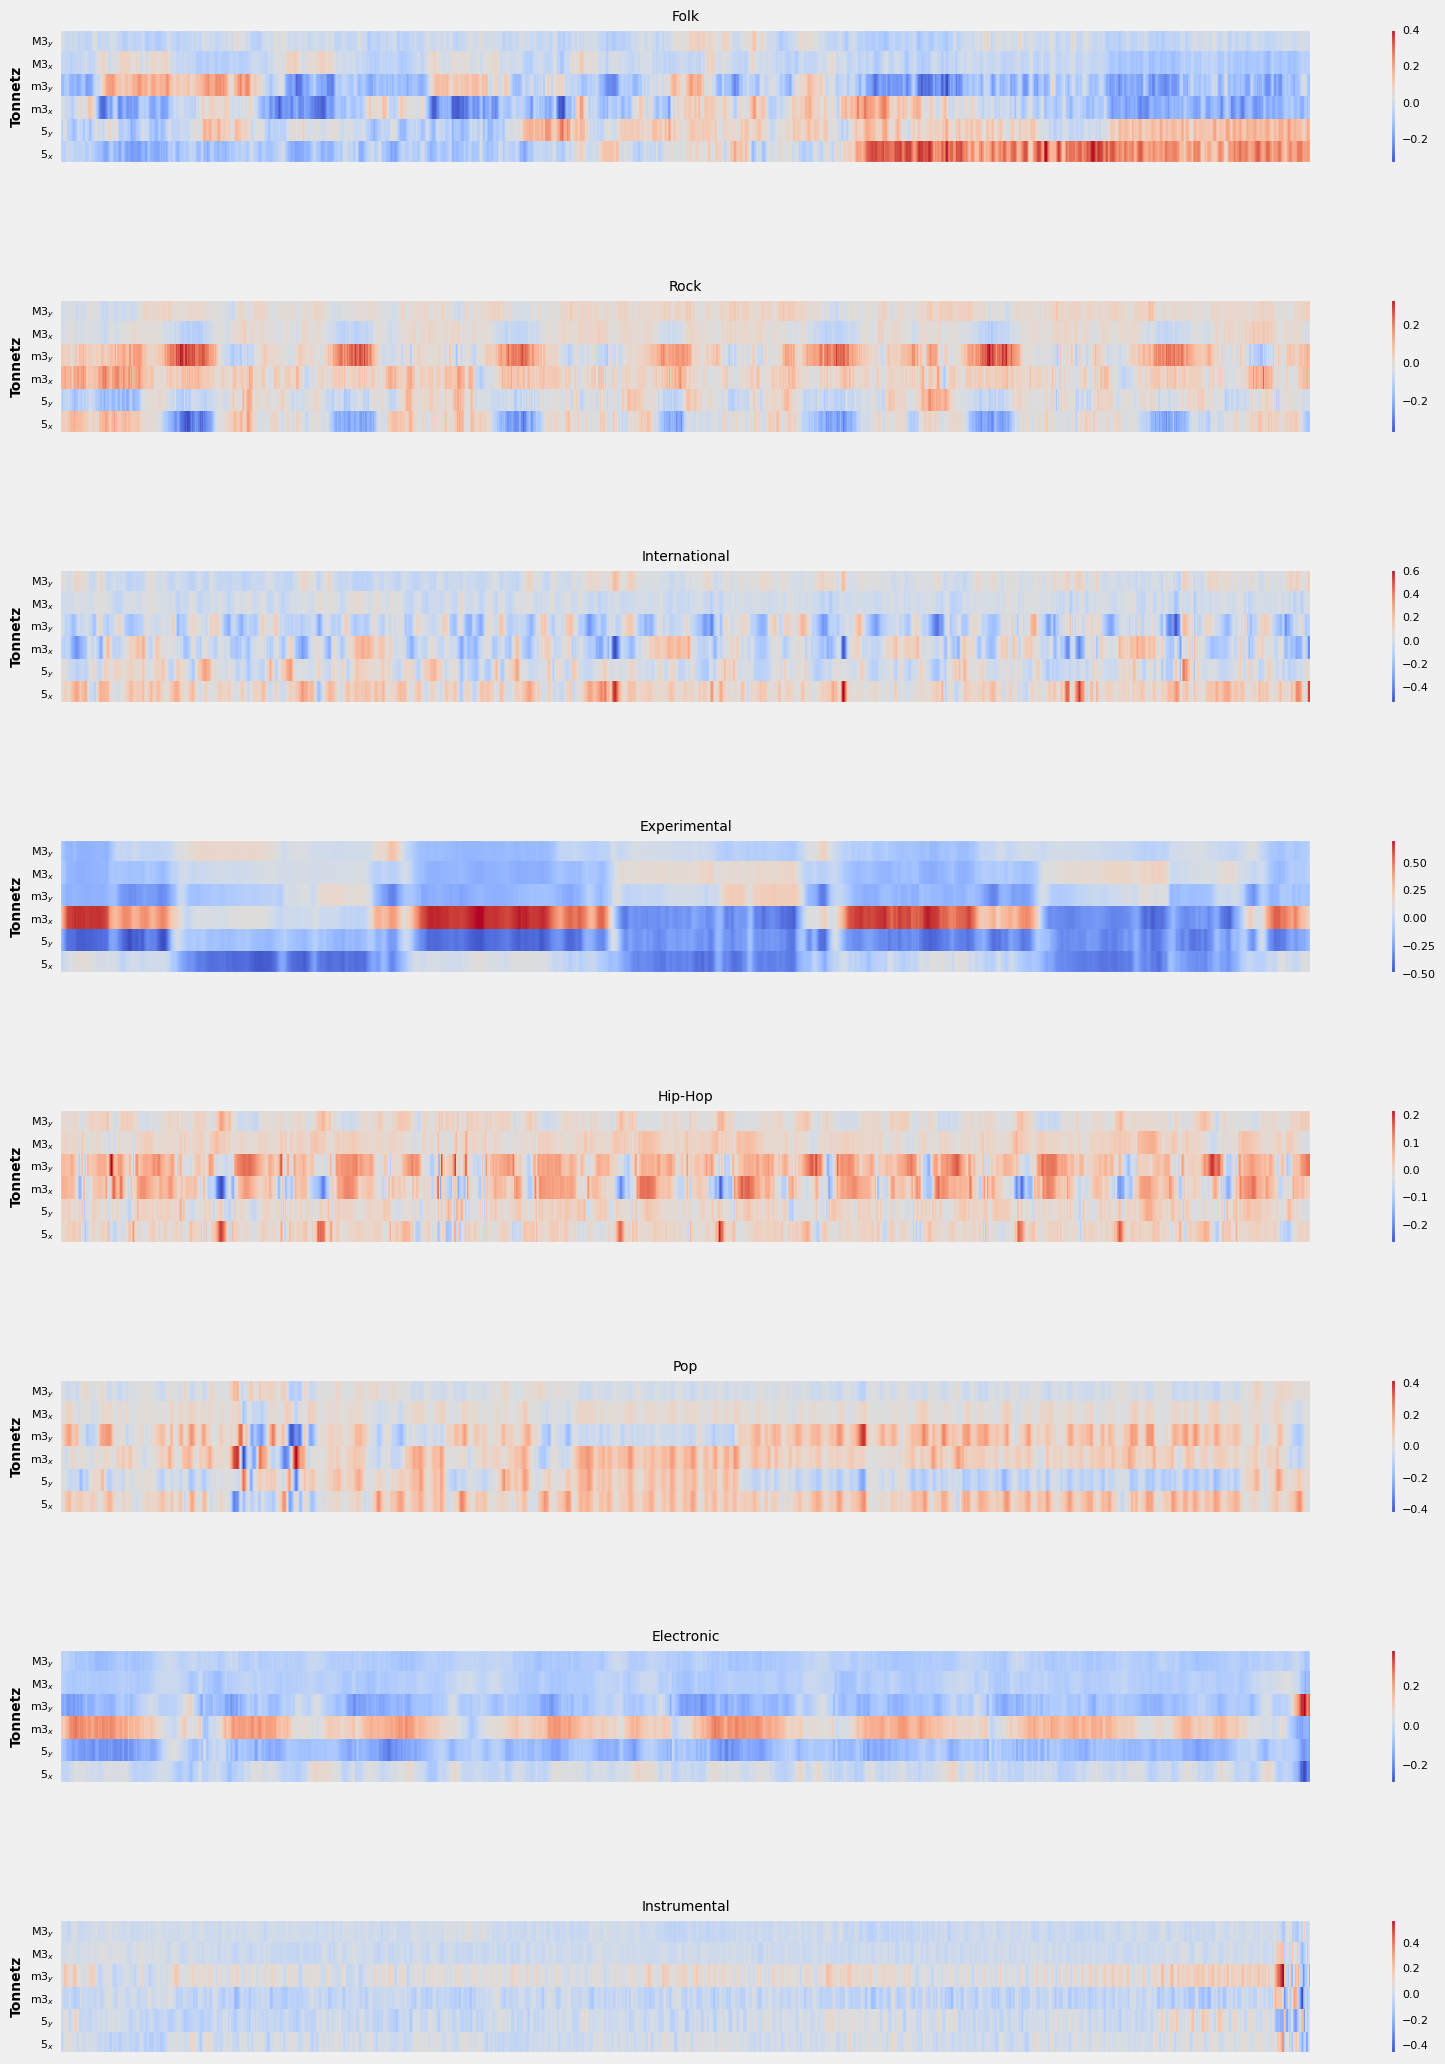

In [23]:
plt.figure(figsize=(18, 25))

i=1

for x in genres:

    plt.subplot(8, 1, i)
    
    tonnetz = librosa.feature.tonnetz(y=x, sr=sr)
    librosa.display.specshow(tonnetz, y_axis='tonnetz')
    plt.colorbar()
    plt.title('Tonal Centroids (Tonnetz)')

    plt.title(genres_List[i-1])
    plt.subplots_adjust(hspace = 1)
    i=i+1

$$ RMSE $$

Consideriamo un segnale $x$. 

L'energia di un segnale è definita come: $ \sum_{n}|x(n)|^2 $.

Il "Root-Mean-Square Energy" (RMSE) è definito come: $ \sqrt {\frac{1}{N}\sum_{n}|x(n)|^{2}} $.

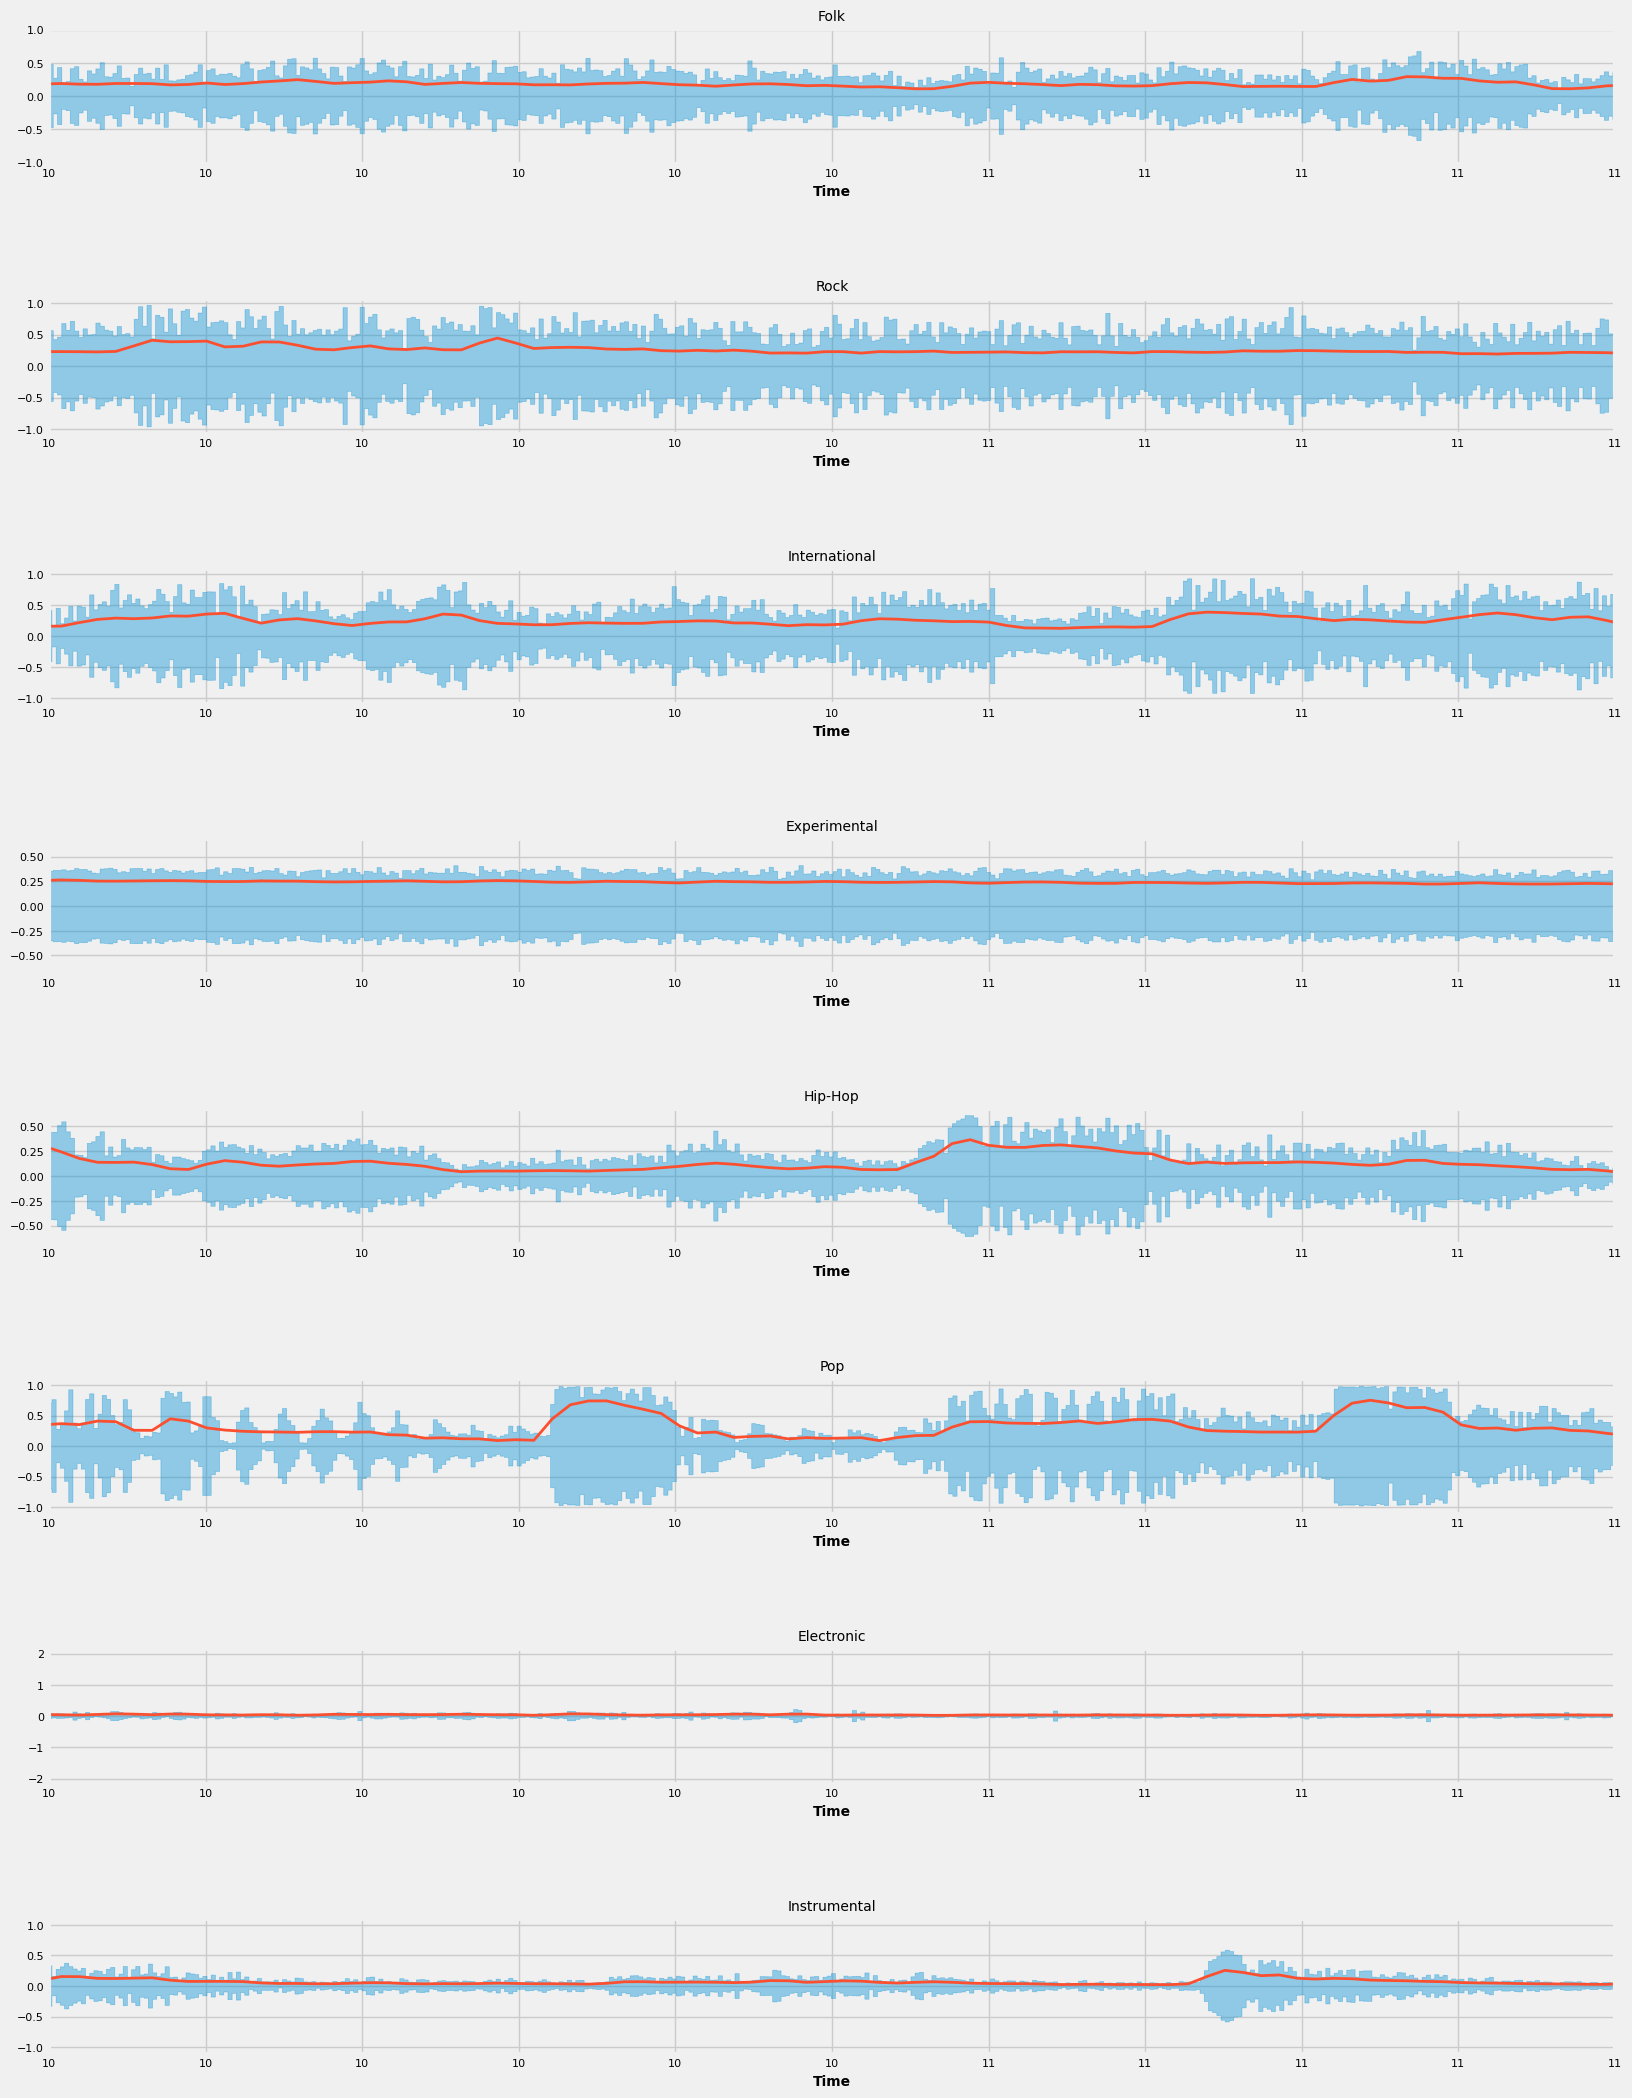

In [24]:
plt.figure(figsize=(18, 25))

hop_length = 256
frame_length = 512

i=1

for x in genres:

    plt.subplot(8, 1, i)
    rmse = librosa.feature.rms(y=x, frame_length=frame_length, hop_length=hop_length, center=True)
    rmse = rmse[0]

    frames = range(len(rmse))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)



    librosa.display.waveshow(x, sr=sr, alpha=0.4)

    plt.plot(t, rmse)

    #plt.xlim(0, t.max())

    plt.xlim(10, 11)
    
    plt.title(genres_List[i-1])
    plt.subplots_adjust(hspace = 1)
    
    i=i+1
    